# Automated Resume Screening

### How to Run Code

To run the code, simply follow these steps:

1. Download [Dataset #1](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset) or [Dataset #2](https://www.kaggle.com/datasets/maitrip/resumes),
2. Change the CSV directories used to load in the CSV file in Sections 1 and 5 below (Ctrl+F for `DATA_PATH`).
3. Ensure all dependencies are installed (see Section 0 on Imports).

### NLP 6120 Final Project

Anuja Prakash Kolse, Oum Parikh, Alexander Wilcox

Prof. Uzair Ahmad

Spring 2024

Our project is designed to enhance the efficiency and fairness of the resume evaluation process by utilizing advanced unsupervised natural language processing (NLP) technologies. We focus on automating the comparison of resumes across a wide range of professions by calculating similarity scores with respect to various job descriptions and exemplary resumes. Our goal is to refine the preliminary selection of candidates, optimizing time management and minimizing unconscious biases that often occur in manual review.

We are conducting a comprehensive exploration of diverse vectorization methods to transform resumes into numerical embeddings. These embeddings are then leveraged to train a sophisticated classification model. Our dual achievements include the effective computation of resume similarity scores through innovative approaches and the development of a classifier capable of assigning a professional category to a given resume. We have employed techniques including Word2Vec, TF-IDF, and GloVe to facilitate these advancements.

### **0. Imports**

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import re
import string
import warnings
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec, KeyedVectors
from gensim.downloader import load
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    make_scorer
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [ ]:
# download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **1. Load Resume Dataset**

In [ ]:
DATA_DIR = '/content/drive/My Drive/NEU/Graduate/CS_6120/NLP_Project/Data/'
DATA_PATH = os.path.join(DATA_DIR, 'Dataset1_UpdatedResumeDataSet.csv')

df = pd.read_csv(
    DATA_PATH
)
df['Category'] = df['Category'].astype(str)
df['Resume'] = df['Resume'].astype(str)

print(f"- There are {format(len(df), ',')} total rows in df.")
df.head(3)

- There are 962 total rows in df.


Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...

### **2. Visualize Resume Dataset**

In [ ]:
job_category = df['Category'].value_counts().reset_index()
job_category = job_category.rename(
    columns = {
        "Category": "Job Category",
        "count": "Count"
    }
)
print(f"- {format(len(job_category), ',')} total rows in job_category.")
job_category.head(25)

- 25 total rows in job_category.


Job Category  Count
0              Java Developer     84
1                     Testing     70
2             DevOps Engineer     55
3            Python Developer     48
4               Web Designing     45
5                          HR     44
6                      Hadoop     42
7                  Blockchain     40
8               ETL Developer     40
9          Operations Manager     40
10               Data Science     40
11                      Sales     40
12        Mechanical Engineer     40
13                       Arts     36
14                   Database     33
15     Electrical Engineering     30
16         Health and fitness     30
17                        PMO     30
18           Business Analyst     28
19           DotNet Developer     28
20         Automation Testing     26
21  Network Security Engineer     25
22              SAP Developer     24
23             Civil Engineer     24
24                   Advocate     20

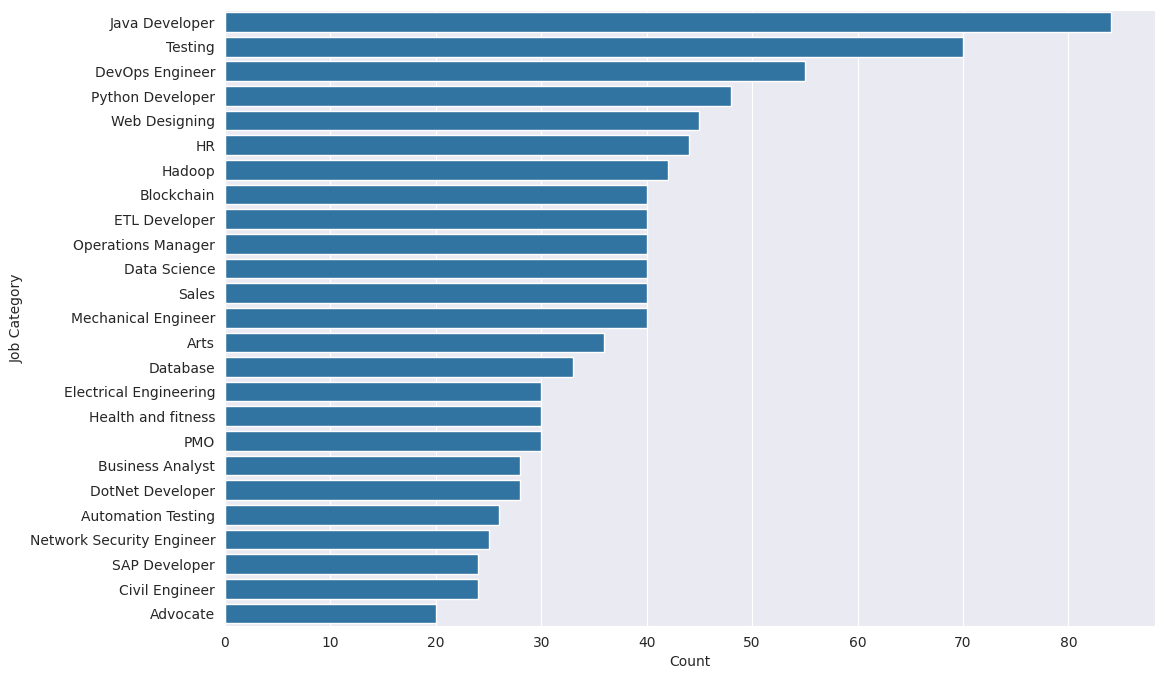

In [ ]:
plt.figure(
    figsize = (12,8)
)
sns.barplot(
    x = job_category['Count'],
    y = job_category['Job Category']
)
plt.show()

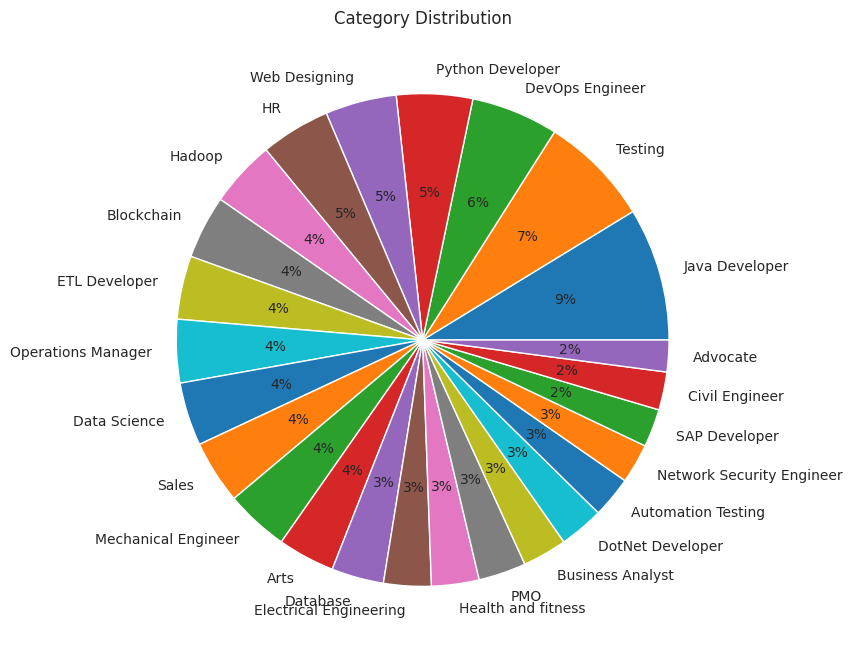

In [ ]:
plt.figure(
    figsize = (12,8)
)
plt.pie(
    job_category['Count'],
    labels = job_category['Job Category'],
    autopct = '%.0f%%'
)
plt.title('Category Distribution')
plt.show()

This pie chart above is a visualization of the distribution of various job categories within a certain dataset or population.

From this chart, we observe the following:

1. The largest single category is for Java Developer roles, making up 9% of the distribution.
2. Testing and Python Developer roles are also significant categories, comprising 7% and 6% respectively.
3. Several fields, including Web Designing, HR, Hadoop, Blockchain, ETL Developer, Operations Manager, Data Science, and Sales, each make up 4% of the distribution.
4. Other technical roles like DotNet Developer, Network Security Engineer, SAP Developer, and Civil Engineer are represented with smaller proportions ranging from 2% to 3%.
5. There are also categories for non-technical roles such as Advocate and PMO (Project Management Office), each with 2%.
6. The smallest identified categories, each with 3%, cover a range of jobs, including Mechanical Engineer, Arts, Database, Electrical Engineering, Health and Fitness, and Business Analyst.

### **3. Preprocessing Resume Data**

In [ ]:
def preprocess(
    text: str
) -> str:
    """
    Purpose: Prepares text for NLP tasks by normalizing it. This includes converting to lowercase,
        removing punctuation, tokenizing, filtering out stopwords, and lemmatizing.
    :param text: str representing raw text to be preprocessed.
    :return: str representing a processed string with basic normalization applied, suitable for
        downstream NLP tasks.
    """
    # lowercasing
    text = text.lower()

    # removing punctuation
    text = re.sub(
        pattern = f'[{string.punctuation}]',
        repl = '',
        string = text
    )

    # tokenization
    tokens = word_tokenize(
        text = text
    )

    # removing stopwords
    tokens = [
        token for token in tokens if token not in stopwords.words('english')
    ]

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(token) for token in tokens
    ]

    # joining tokens back to form a string
    return ' '.join(tokens)

The `preprocess` function defined above performs following operations:

- <ins>Lowercasing:</ins> Converts all characters in the text to lowercase. This is done to ensure that the same word in different cases (e.g., "Word" and "word") is treated as the same word.

- <ins>Removing Punctuation:</ins> Removes all punctuation marks from the text using a regular expression.

- <ins>Tokenization:</ins> Tokenization is a fundamental step in text processing as it breaks the text into manageable pieces for further analysis. This splits the text into individual words or tokens using the word_tokenize function from the nltk library.

- <ins>Removing Stopwords:</ins> Filters out common words that are considered "stopwords" (e.g., "the", "is", "and").

- <ins>Lemmatization:</ins> Reduces words to their base or root form using a WordNetLemmatizer. For example, "running" is lemmatized to "run". Lemmatization is performed here because it produces more meaningful and grammatically correct base forms.

- <ins>Joining Tokens Back:</ins> After processing, the tokens are joined back together into a single string, separated by spaces. This is done because some algorithms or vectorizers expect the input as a single string rather than a list of tokens.

The function returns the preprocessed text as a single string, ready for further processing or vectorization.

In [ ]:
# apply preprocessing function to resumes
df['Cleaned_Resume'] = df['Resume'].apply(
    preprocess
)

In [ ]:
df.head()

Category                                             Resume  \
0  Data Science  Skills * Programming Languages: Python (pandas...   
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...   
2  Data Science  Areas of Interest Deep Learning, Control Syste...   
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...   
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...   

                                      Cleaned_Resume  
0  skill programming language python panda numpy ...  
1  education detail may 2013 may 2017 uitrgpv dat...  
2  area interest deep learning control system des...  
3  skill â¢ r â¢ python â¢ sap hana â¢ tablea...  
4  education detail mca ymcaust faridabad haryana...

In [ ]:
# Display the first 5 preprocessed resumes
print(df[['Resume', 'Cleaned_Resume']].head(5))

                                              Resume  \
0  Skills * Programming Languages: Python (pandas...   
1  Education Details \r\nMay 2013 to May 2017 B.E...   
2  Areas of Interest Deep Learning, Control Syste...   
3  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...   
4  Education Details \r\n MCA   YMCAUST,  Faridab...   

                                      Cleaned_Resume  
0  skill programming language python panda numpy ...  
1  education detail may 2013 may 2017 uitrgpv dat...  
2  area interest deep learning control system des...  
3  skill â¢ r â¢ python â¢ sap hana â¢ tablea...  
4  education detail mca ymcaust faridabad haryana...  


Considering a few job descriptions for testing in `job_descriptions`.

In [ ]:
# job descriptions
job_descriptions = [
    "Data scientist with experience in Python and machine learning",
    "Web developer with knowledge in HTML, CSS, and JavaScript",
    "Graphic designer with expertise in Adobe Creative Suite"
]

### **4. Vectorization**

#### 4.1) TF-IDF Vectorizer

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (i.e., a corpus). It is commonly used in text mining and information retrieval to transform text into a meaningful representation of numbers which can be used for various machine learning algorithms. The TF-IDF value increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. This helps to adjust for the fact that some words appear more frequently in general.

TF-IDF consists of two components:
1. <ins>Term Frequency (TF):</ins> This measures how frequently a term occurs in a document. It is calculated as the number of times a term appears in a document divided by the total number of terms in that document.

2. <ins>Inverse Document Frequency (IDF):</ins> This measures how important a term is within the entire corpus. It is calculated as the logarithm of the number of documents divided by the number of documents that contain the term.

The TF-IDF value is calculated by multiplying TF and IDF: <b><i>TF-IDF = TF × IDF</i></b>

This value is high for terms that are very specific and characteristic of a particular document in the corpus, and low for terms that are common across many documents. This helps in distinguishing the relevance of terms in a specific document compared to their relevance across a broader set of documents.

In [ ]:
class TfIdf:

    def __init__(
        self,
        flag_sublinear_tf: bool,
        no_features: int
    ) -> None:
        """
        Purpose: Initializes the TF-IDF vectorizer with specified configurations.
        :param flag_sublinear_tf: bool indicating if sublinear tf scaling is applied.
        :param no_features: int indicating the maximum number of features to consider.
        :return: None.
        """
        # instantiate TF-IDF vectorizer attribute
        self.vectorizer = TfidfVectorizer(
            sublinear_tf = flag_sublinear_tf,
            stop_words = 'english',
            max_features = no_features
        )

    def test_job_descriptions(
        self,
        df: pd.DataFrame,
        job_descriptions: List[str]
    ) -> None:
        """
        Purpose: Fits the vectorizer on resumes and evaluates job descriptions
            against them using cosine similarity.
        :param df: pd.DataFrame containing resumes and their details.
        :param job_descriptions: List[str] of job descriptions to compare
            against the resumes.
        :return: None.
        """
        # fit vectorizer on resumes
        tfidf_matrix = self.vectorizer.fit_transform(
            raw_documents = df['Cleaned_Resume']
        )

        # loop through each job description
        for i, job_description in enumerate(job_descriptions):

            # preprocess job description
            job_description = preprocess(
                text = job_description
            )

            # transform job description using the fitted vectorizer
            job_vec = self.vectorizer.transform(
                raw_documents = [job_description]
            )

            # calculate cosine similarity between job description and resumes
            similarity_scores = cosine_similarity(
                job_vec, tfidf_matrix
            )

            # add similarity scores to dataframe
            df[f'Similarity_Job_{i+1}'] = similarity_scores[0]

            # rank resumes based on similarity scores
            ranked_resumes = df.sort_values(
                by = f'Similarity_Job_{i+1}',
                ascending = False
            )

            # print top 5 shortlisted resumes for each job
            print(f"Top 5 resumes for Job {i+1} ({job_description}):")
            print(ranked_resumes[['Category', f'Similarity_Job_{i+1}']].head(5))
            print("\n")

**Parameters Used:**

1. <ins>`sublinear_tf`:</ins> When set to True, this parameter applies a sublinear transformation to the term frequency (TF) part of the TF-IDF calculation. Specifically, it uses 1+log(TF) instead of TF itself. This transformation is used to reduce the influence of very high term frequencies, as they may not be as informative as lower frequencies. It helps to prevent a few highly frequent terms from dominating the TF-IDF values.

2. <ins>`stop_words`:</ins> Specifies a list of words that should be ignored in the analysis. In this case, "english" indicates that the built-in list of English stopwords provided by scikit-learn should be used.

3. <ins>`max_features`:</ins> Limits the number of features (i.e., unique words or terms) to consider when creating the TF-IDF matrix. In this case, max_features=1500 means that only the top 1,500 terms ordered by term frequency across the corpus will be included in the matrix. This can be useful for reducing the dimensionality of the data and focusing on the most relevant terms.

##### TF-IDF Vectorizer, Experiment #1:

Hyperparameters:
  - `sublinear_tf = True`
  - `max_features = 1500`

In [ ]:
obj_tfidf = TfIdf(
    flag_sublinear_tf = True,
    no_features = 1_500
)
obj_tfidf.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_1
26  Data Science          0.381067
16  Data Science          0.381067
6   Data Science          0.381067
36  Data Science          0.381067
38  Data Science          0.377179


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
             Category  Similarity_Job_2
831  DotNet Developer          0.265948
824  DotNet Developer          0.265948
838  DotNet Developer          0.265948
845  DotNet Developer          0.265948
832  DotNet Developer          0.239685


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
          Category  Similarity_Job_3
144  Web Designing          0.167362
174  Web Designing          0.167362
184  Web Designing          0.167362
154  Web Designing          0.167362
159  Web Designing          0.167362




##### TF-IDF Vectorizer, Experiment #2:

Hyperparameters:
  - `sublinear_tf = False`
  - `max_features = 1500`

In [ ]:
obj_tfidf = TfIdf(
    flag_sublinear_tf = False,
    no_features = 1_500
)
obj_tfidf.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_1
8   Data Science          0.506119
28  Data Science          0.506119
18  Data Science          0.506119
38  Data Science          0.506119
37  Data Science          0.501701


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
          Category  Similarity_Job_2
176  Web Designing          0.254983
181  Web Designing          0.254983
171  Web Designing          0.254983
166  Web Designing          0.254983
141  Web Designing          0.254983


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
          Category  Similarity_Job_3
144  Web Designing          0.153451
149  Web Designing          0.153451
159  Web Designing          0.153451
179  Web Designing          0.153451
154  Web Designing          0.153451




##### TF-IDF Vectorizer, Experiment #3:

Hyperparameters:
  - `sublinear_tf = True`
  - `max_features = 500`

In [ ]:
obj_tfidf = TfIdf(
    flag_sublinear_tf = True,
    no_features = 500
)
obj_tfidf.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_1
38  Data Science          0.530407
8   Data Science          0.530407
28  Data Science          0.530407
18  Data Science          0.530407
16  Data Science          0.508508


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
             Category  Similarity_Job_2
824  DotNet Developer          0.298982
831  DotNet Developer          0.298982
838  DotNet Developer          0.298982
845  DotNet Developer          0.298982
839  DotNet Developer          0.296076


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
          Category  Similarity_Job_3
165  Web Designing          0.203596
142  Web Designing          0.203596
157  Web Designing          0.203596
172  Web Designing          0.203596
155  Web Designing          0.203596




##### TF-IDF Vectorizer, Experiment #4:

Hyperparameters:
  - `sublinear_tf = False`
  - `max_features = 500`

In [ ]:
obj_tfidf = TfIdf(
    flag_sublinear_tf = False,
    no_features = 500
)
obj_tfidf.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_1
37  Data Science          0.661311
27  Data Science          0.661311
7   Data Science          0.661311
17  Data Science          0.661311
28  Data Science          0.656449


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
          Category  Similarity_Job_2
151  Web Designing          0.281595
156  Web Designing          0.281595
146  Web Designing          0.281595
141  Web Designing          0.281595
161  Web Designing          0.281595


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
          Category  Similarity_Job_3
163  Web Designing          0.182867
158  Web Designing          0.182867
148  Web Designing          0.182867
143  Web Designing          0.182867
178  Web Designing          0.182867




##### TF-IDF Vectorizer, Experiment #5:

Hyperparameters:
  - `sublinear_tf = False`
  - `max_features = 1000`

In [ ]:
obj_tfidf = TfIdf(
    flag_sublinear_tf = False,
    no_features = 1_000
)
obj_tfidf.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_1
38  Data Science          0.561058
28  Data Science          0.561058
18  Data Science          0.561058
8   Data Science          0.561058
27  Data Science          0.555700


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
       Category  Similarity_Job_2
855  Blockchain          0.265578
890  Blockchain          0.265578
860  Blockchain          0.265578
865  Blockchain          0.265578
870  Blockchain          0.265578


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
          Category  Similarity_Job_3
148  Web Designing          0.162158
143  Web Designing          0.162158
163  Web Designing          0.162158
173  Web Designing          0.162158
153  Web Designing          0.162158




##### TF-IDF Vectorizer, Experiment #6:

Hyperparameters:
  - `sublinear_tf = False`
  - `max_features = 250`

In [ ]:
obj_tfidf = TfIdf(
    flag_sublinear_tf = True,
    no_features = 250
)
obj_tfidf.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_1
38  Data Science          0.601893
18  Data Science          0.601893
28  Data Science          0.601893
8   Data Science          0.601893
26  Data Science          0.580539


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
       Category  Similarity_Job_2
870  Blockchain          0.399722
890  Blockchain          0.399722
855  Blockchain          0.399722
860  Blockchain          0.399722
865  Blockchain          0.399722


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
            Category  Similarity_Job_3
0       Data Science               0.0
721         Database               0.0
633  DevOps Engineer               0.0
634  DevOps Engineer               0.0
635  DevOps Engineer               0.0




##### TF-IDF Vectorizer Experiment Observations:

Based on the experiments above, we find out that setting the hyperparameter `sublinear_tf` to False gives better result than setting it to True which means that not applying the transformation helps in calculating the similarity score. But if we increase the number of features, we find that the similarity does not relate to the correct category and thus we can conclude that the optimal hyperparameters are:
- `sublinear_tf = False`
- `max_features = 500`

#### 4.2) GloVe Vectorization

GloVe (Global Vectors for Word Representation) is a model for distributed word representation. It is an unsupervised learning algorithm developed by Stanford University researchers to generate word embeddings by aggregating global word-word co-occurrence statistics from a corpus. The resulting embeddings capture both the semantic and syntactic information of words, making them useful for various natural language processing (NLP) tasks.

Stepwise approach to how the GloVe model generates word embeddings:

1. <ins>Collect Data:</ins> Gather a large text corpus that represents the language you want to model.

2. <ins>Build a Co-occurrence Matrix:</ins> Create a matrix where each element $X_{i,j}$ represents the number of times word $i$ occurs in the context of word $j$ within a specified window size. The window size determines how many words surrounding a target word will be considered as its context.

3. <ins>Calculate Probabilities:</ins> Transform the co-occurrence counts in the matrix into probabilities. Specifically, for each word pair $(i,j)$, calculate the probability $P_{i,j}$ that word $i$ appears in the context of word $j$.

4. <ins>Define a Loss Function:</ins> The loss function in GloVe is designed to minimize the difference between the dot product of the embeddings of two words and the logarithm of their co-occurrence probability. The function also includes weighting factors to prevent overemphasis on rare or too frequent word pairs.

5. <ins>Train the Model:</ins> Optimize the loss function to learn the word vectors. This involves adjusting the embeddings for each word in a way that the dot product of the embeddings of two words approximates the logarithm of their co-occurrence probability.

6. <ins>Extract Word Embeddings:</ins> After training, the resulting word vectors are extracted. These vectors capture both the syntactic and semantic information of words based on their co-occurrence statistics in the corpus.

In [ ]:
# load a pre-trained GloVe model through gensim
model_glove = load(
    'glove-wiki-gigaword-300'
)

In [ ]:
# function to vectorize text using the pre-trained model
def vectorize_text(
    text: str,
    model
) -> np.ndarray:
    """
    Purpose: Converts input text into a fixed-size vector using a pre-trained
        GloVe model by averaging the vectors of the words present in the text.
    :param text: str representing text to be vectorized.
    :param model: A pre-trained GloVe model loaded via gensim's KeyedVectors.
    :return: np.ndarrray representing the averaged vector of the text. Returns
        a zero vector if none of the words in the text are in the model's vocabulary.
    """
    words = word_tokenize(
        text = text
    )
    valid_words = [
        word for word in words if word in model.key_to_index
    ]

    if valid_words:
        return np.mean(
            model[valid_words],
            axis = 0
        )
    else:
        return np.zeros(model.vector_size)

In [ ]:
# vectorize resumes using GloVe
df['Vec_Resume_Glove'] = df['Cleaned_Resume'].apply(
    lambda resume_text: vectorize_text(
        text = resume_text,
        model = model_glove
    )
)

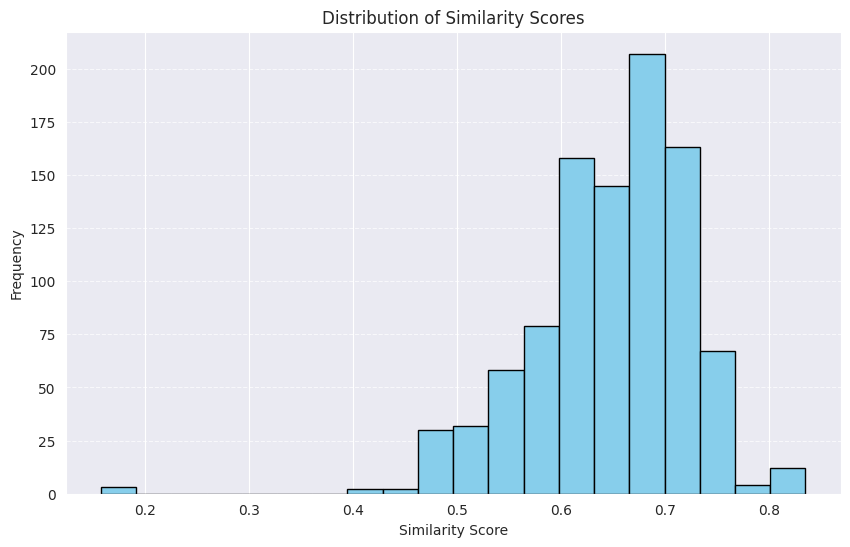

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_Glove_1
28  Data Science                0.835349
38  Data Science                0.835349
18  Data Science                0.835349
8   Data Science                0.835349
37  Data Science                0.825351




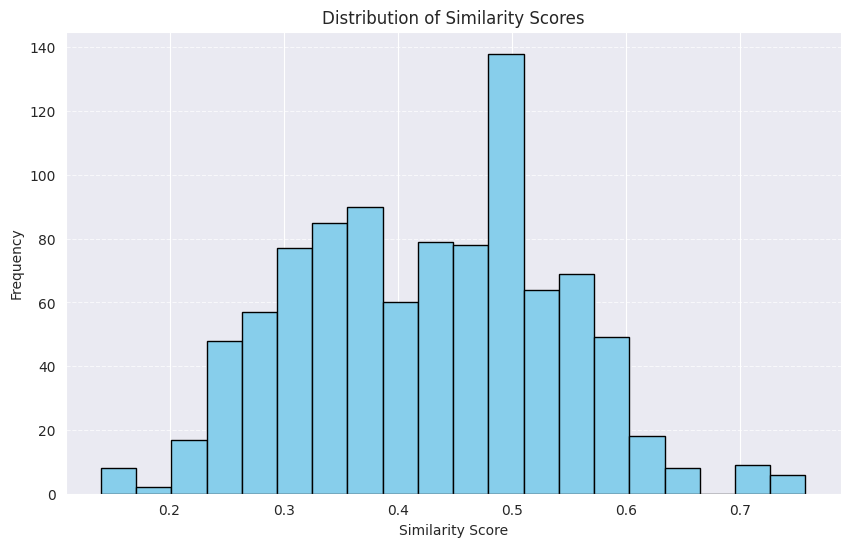

Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
           Category  Similarity_Job_Glove_2
329  Java Developer                0.757021
343  Java Developer                0.757021
385  Java Developer                0.757021
399  Java Developer                0.757021
357  Java Developer                0.757021




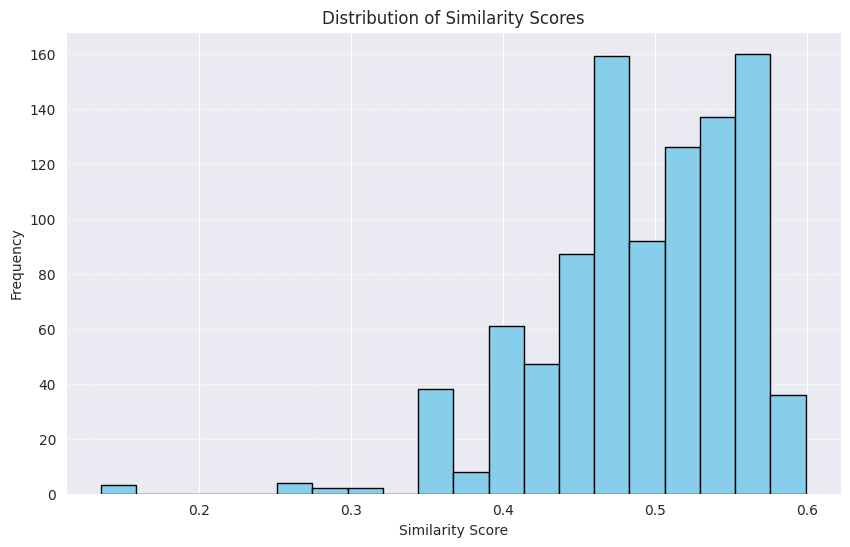

Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
          Category  Similarity_Job_Glove_3
154  Web Designing                0.599178
149  Web Designing                0.599178
174  Web Designing                0.599178
179  Web Designing                0.599178
184  Web Designing                0.599178




In [ ]:
# loop through each job description
for i, job_description in enumerate(job_descriptions):

    # preprocess job description
    job_description = preprocess(
        text = job_description
    )

    # transform job description using the fitted vectorizer
    job_vec = vectorize_text(
        text = job_description,
        model = model_glove
    )

    # calculate cosine similarity between the job description and the resumes
    similarity_scores = [
        np.dot(job_vec, resume_vec) / (np.linalg.norm(job_vec) * np.linalg.norm(resume_vec))
        if np.linalg.norm(resume_vec) != 0
        else 0
        for resume_vec in df['Vec_Resume_Glove']
    ]

    # create plot
    plt.figure(
        figsize = (10, 6)
    )
    plt.hist(
        x = similarity_scores,
        bins = 20,
        color = 'skyblue',
        edgecolor = 'black'
    )
    plt.title('Distribution of Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.grid(
        axis = 'y',
        linestyle = '--',
        alpha = 0.7
    )
    plt.show()

    # add similarity scores to DataFrame
    df[f'Similarity_Job_Glove_{i+1}'] = similarity_scores

    # rank resumes based on similarity scores
    ranked_resumes = df.sort_values(
        by = f'Similarity_Job_Glove_{i+1}',
        ascending = False
    )

    # display top 5 shortlisted resumes for each job
    print(f"Top 5 resumes for Job {i+1} ({job_description}):")
    print(ranked_resumes[['Category', f'Similarity_Job_Glove_{i+1}']].head(5))
    print("\n")

#### 4.3) Word2Vec Vectorization

Word2Vec is a popular technique in Natural Language Processing (NLP) used to create word embeddings, which are vector representations of words. These embeddings capture semantic and syntactic information about words, allowing them to be used effectively in various NLP tasks.

Word2Vec works by training a shallow neural network to reconstruct linguistic contexts of words in a corpus. It does this by either predicting a word based on its context (Continuous Bag of Words, or CBOW) or predicting the context based on a word (Skip-Gram). Through this process, words that appear in similar contexts tend to have similar embeddings, capturing their semantic relationships. The models use a sliding window approach, moving across the text corpus and considering each word (or a subset of words) along with its neighboring context words to perform their respective prediction tasks.

In [ ]:
class CustomWord2Vec:

    def __init__(
        self,
        df: pd.DataFrame,
        vector_size: int,
        window: int,
        min_count: int,
        workers: int,
        sg: int
    ) -> None:
        """
        Purpose: Initializes a Word2Vec model with specific configurations and trains it on
            tokenized text from a DataFrame.
        :param df: pd.DataFrame containing resumes and their details.
        :param vector_size: int representing the dimensionality of the word vectors.
        :param window: int representing the maximum distance between the current and predicted
            word within a sentence.
        :param min_count: int representing the threshold below which all words with a total
            frequency less than min_count are ignored.
        :param workers: int representing the total number of worker threads to use.
        :param sg: int representing the training algorithm (1 for Skip-Gram; otherwise CBOW).
        :return: None.
        """
        self.model_word2vec = Word2Vec(
            sentences = df['Tokenized'],
            vector_size = vector_size,
            window = window,
            min_count = min_count,
            workers = workers,
            sg = sg
        )

    def document_vector(
        self,
        doc: List[str]
    ) -> np.ndarray:
        """
        Purpose: Vectorizes a document by averaging the vectors of words present in the
            document, using the trained Word2Vec model.
        :param doc: List[str] representing tokenized words in a document.
        :return: np.ndarray representing the averaged word vector for the document.
            Returns a zero vector if document has no valid words.
        """
        # remove out-of-vocabulary words
        doc = [
            word for word in doc
            if word in self.model_word2vec.wv.index_to_key
        ]
        if doc:
            return np.mean(
                self.model_word2vec.wv[doc],
                axis = 0
            )
        else:
            return np.zeros(self.model_word2vec.vector_size)

    def test_job_descriptions(
        self,
        df: pd.DataFrame,
        job_descriptions: List[str]
    ) -> None:
        """
        Purpose: Compares job descriptions against resumes by vectorizing them and calculating cosine
            similarity, then ranks resumes for each job.
        :param df: pd.DataFrame containing resumes with a 'Tokenized' column for vectorization.
        :param job_descriptions: List of strings with job descriptions to compare against resumes.
        :return: None.
        """
        # create document vectors for each resume
        df['Vec_Resume_Word2Vec'] = df['Tokenized'].apply(
            lambda resume: self.document_vector(
                doc = resume
            )
        )

        # loop through each job description
        for i, job_description in enumerate(job_descriptions):

            # preprocess the job description
            job_description = preprocess(
                text = job_description
            )

            # transform job description using the fitted vectorizer
            job_vec = self.document_vector(
                doc = simple_preprocess(
                    doc = job_description
                )
            )

            # calculate cosine similarity between the job description and the resumes
            similarity_scores = [
                np.dot(job_vec, doc_vec) / (np.linalg.norm(job_vec) * np.linalg.norm(doc_vec))
                if np.linalg.norm(doc_vec) != 0
                else 0
                for doc_vec in df['Vec_Resume_Word2Vec']
            ]

            # add similarity scores to the dataframe
            df[f'Similarity_Job_Word2Vec_{i+1}'] = similarity_scores

            # rank resumes based on similarity scores
            ranked_resumes = df.sort_values(
                by = f'Similarity_Job_Word2Vec_{i+1}',
                ascending = False
            )

            # display top 5 shortlisted resumes for each job
            print(f"Top 5 resumes for Job {i+1} ({job_description}):")
            print(ranked_resumes[['Category', f'Similarity_Job_Word2Vec_{i+1}']].head(5))
            print("\n")

**Parameters Used:**

1. <ins>`sentences`:</ins> This is the input data for training the model. In this case, it is a list of tokenized sentences. Each sentence is a list of words.

2. <ins>`vector_size`:</ins> This specifies the dimensionality of the word embeddings. In this case, each word will be represented as a 50-dimensional vector. A higher dimensionality can capture more information but may also require more data to train effectively.

3. <ins>`window`:</ins> This parameter defines the maximum distance between the current and predicted word within a sentence. In this case, a window size of 7 means that the model will consider a context of 7 words to the left and 7 words to the right of the target word when making predictions in the Skip-gram model.

4. <ins>`min_count`:</ins> This parameter specifies the minimum frequency count of words. Words that appear fewer than min_count times across all sentences will be ignored during training. In this case, min_count=1 means that no words will be ignored based on frequency.

5. <ins>`workers`:</ins> This parameter determines the number of worker threads used to train the model. More workers can speed up training on multi-core machines. In this case, 4 worker threads will be used.

6. <ins>`sg`:</ins> This parameter specifies the training algorithm. When sg=1, the Skip-Gram model is used; otherwise, the Continuous Bag of Words (CBOW) model is used.

In [ ]:
# tokenize and preprocess the text
df['Tokenized'] = df['Cleaned_Resume'].apply(
    lambda resume: simple_preprocess(
        doc = resume
    )
)

##### Word2Vec Vectorizer, Experiment #1:

Hyperparameters:

- `vector_size = 50`
- `window = 5`
- `min_count = 1`
- `workers = 4`
- `sg = 1`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 50,
    window = 5,
    min_count = 1,
    workers = 4,
    sg = 1
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_Word2Vec_1
7   Data Science                   0.861147
37  Data Science                   0.861147
27  Data Science                   0.861147
17  Data Science                   0.861147
16  Data Science                   0.853186


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
           Category  Similarity_Job_Word2Vec_2
399  Java Developer                   0.927695
357  Java Developer                   0.927695
371  Java Developer                   0.927695
329  Java Developer                   0.927695
343  Java Developer                   0.927695


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
          Category  Similarity_Job_Word2Vec_3
184  Web Designing                   0.872151
144  Web Designing                   0.872151
149  Web Designing                   0.872151
154  Web Designing                   0.87215

##### Word2Vec Vectorizer, Experiment #2:

Hyperparameters:

- `vector_size = 50`
- `window = 7`
- `min_count = 1`
- `workers = 4`
- `sg = 1`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 50,
    window = 7,
    min_count = 1,
    workers = 4,
    sg = 1
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_Word2Vec_1
37  Data Science                   0.873060
7   Data Science                   0.873060
27  Data Science                   0.873060
17  Data Science                   0.873060
26  Data Science                   0.856598


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
           Category  Similarity_Job_Word2Vec_2
343  Java Developer                   0.916262
371  Java Developer                   0.916262
385  Java Developer                   0.916262
329  Java Developer                   0.916262
399  Java Developer                   0.916262


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
          Category  Similarity_Job_Word2Vec_3
184  Web Designing                   0.865449
154  Web Designing                   0.865449
149  Web Designing                   0.865449
169  Web Designing                   0.86544

##### Word2Vec Vectorizer, Experiment #3:

Hyperparameters:

- `vector_size = 50`
- `window = 3`
- `min_count = 1`
- `workers = 4`
- `sg = 1`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 50,
    window = 3,
    min_count = 1,
    workers = 4,
    sg = 1
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_Word2Vec_1
36  Data Science                   0.862421
6   Data Science                   0.862421
16  Data Science                   0.862421
26  Data Science                   0.862421
27  Data Science                   0.862076


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
           Category  Similarity_Job_Word2Vec_2
399  Java Developer                   0.938995
385  Java Developer                   0.938995
357  Java Developer                   0.938995
343  Java Developer                   0.938995
371  Java Developer                   0.938995


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
               Category  Similarity_Job_Word2Vec_3
457  Automation Testing                   0.888575
470  Automation Testing                   0.888575
169       Web Designing                   0.887658
184       Web Designing 

##### Word2Vec Vectorizer, Experiment #4:

Hyperparameters:

- `vector_size = 100`
- `window = 5`
- `min_count = 1`
- `workers = 4`
- `sg = 1`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 100,
    window = 5,
    min_count = 1,
    workers = 4,
    sg = 1
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_Word2Vec_1
17  Data Science                   0.838097
37  Data Science                   0.838097
7   Data Science                   0.838097
27  Data Science                   0.838097
26  Data Science                   0.834394


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
           Category  Similarity_Job_Word2Vec_2
357  Java Developer                   0.902719
343  Java Developer                   0.902719
371  Java Developer                   0.902719
329  Java Developer                   0.902719
385  Java Developer                   0.902719


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
          Category  Similarity_Job_Word2Vec_3
164  Web Designing                   0.854652
179  Web Designing                   0.854652
149  Web Designing                   0.854652
174  Web Designing                   0.85465

##### Word2Vec Vectorizer, Experiment #5:

Hyperparameters:

- `vector_size = 100`
- `window = 3`
- `min_count = 1`
- `workers = 4`
- `sg = 1`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 100,
    window = 3,
    min_count = 1,
    workers = 4,
    sg = 1
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_Word2Vec_1
26  Data Science                   0.842969
16  Data Science                   0.842969
36  Data Science                   0.842969
6   Data Science                   0.842969
27  Data Science                   0.836025


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
           Category  Similarity_Job_Word2Vec_2
385  Java Developer                   0.930865
329  Java Developer                   0.930865
357  Java Developer                   0.930865
343  Java Developer                   0.930865
371  Java Developer                   0.930865


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
          Category  Similarity_Job_Word2Vec_3
164  Web Designing                   0.875227
174  Web Designing                   0.875227
144  Web Designing                   0.875227
149  Web Designing                   0.87522

##### Word2Vec Vectorizer, Experiment #6:

Hyperparameters:

- `vector_size = 50`
- `window = 3`
- `min_count = 1`
- `workers = 4`
- `sg = 0`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 50,
    window = 3,
    min_count = 1,
    workers = 4,
    sg = 0
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_Word2Vec_1
36  Data Science                   0.881533
16  Data Science                   0.881533
6   Data Science                   0.881533
26  Data Science                   0.881533
27  Data Science                   0.857172


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
           Category  Similarity_Job_Word2Vec_2
357  Java Developer                   0.956233
371  Java Developer                   0.956233
399  Java Developer                   0.956233
329  Java Developer                   0.956233
385  Java Developer                   0.956233


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
               Category  Similarity_Job_Word2Vec_3
457  Automation Testing                   0.942529
470  Automation Testing                   0.942529
155       Web Designing                   0.937603
142       Web Designing 

##### Word2Vec Vectorizer, Experiment #7:

Hyperparameters:

- `vector_size = 50`
- `window = 5`
- `min_count = 1`
- `workers = 4`
- `sg = 0`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 50,
    window = 5,
    min_count = 1,
    workers = 4,
    sg = 0
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
        Category  Similarity_Job_Word2Vec_1
26  Data Science                   0.849957
16  Data Science                   0.849957
6   Data Science                   0.849957
36  Data Science                   0.849957
37  Data Science                   0.843039


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
           Category  Similarity_Job_Word2Vec_2
343  Java Developer                   0.948638
371  Java Developer                   0.948638
329  Java Developer                   0.948638
385  Java Developer                   0.948638
399  Java Developer                   0.948638


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
               Category  Similarity_Job_Word2Vec_3
470  Automation Testing                   0.922676
457  Automation Testing                   0.922676
152       Web Designing                   0.907207
172       Web Designing 

##### Word2Vec Vectorizer Experiment Observations:

Based on the experiments above, optimal parameters were:
- `vector_size = 50`
- `window = 3`

We can also observe that the Skip-Gram approach performs better than CBOW model.

### **5. Modeling**

In [ ]:
DATA_DIR = '/content/drive/My Drive/NEU/Graduate/CS_6120/NLP_Project/Data/'
DATA_PATH = os.path.join(DATA_DIR, 'Dataset1_UpdatedResumeDataSet.csv')

df = pd.read_csv(
    DATA_PATH
)
df['Cleaned_Resume'] = df['Resume'].apply(
    preprocess
)

In [ ]:
# encode the data
label = LabelEncoder()
df['Target'] = label.fit_transform(
    df['Category']
)

In [ ]:
df.head(3)

Category                                             Resume  \
0  Data Science  Skills * Programming Languages: Python (pandas...   
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...   
2  Data Science  Areas of Interest Deep Learning, Control Syste...   

                                      Cleaned_Resume  Target  
0  skill programming language python panda numpy ...       6  
1  education detail may 2013 may 2017 uitrgpv dat...       6  
2  area interest deep learning control system des...       6

#### 5.1) Classification via One-vs-Rest

##### 5.1.1) One-vs-Rest Classifier, TF-IDF Vectorization

In [ ]:
# vectorizing cleaned columns
text = df['Cleaned_Resume'].values
target = df['Target'].values

tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf = False,
    stop_words = 'english',
    max_features = 500
)
tfidf_vectorizer.fit(
    raw_documents = text
)
features = tfidf_vectorizer.transform(
    raw_documents = text
)

print(f"features.shape = {features.shape}")

features.shape = (962, 500)


In [ ]:
# define model
model_tfidf = OneVsRestClassifier(
    estimator = KNeighborsClassifier()
)

In [ ]:
# define CV procedure
cv = KFold(
    n_splits = 5,
    random_state = 21,
    shuffle = True
)

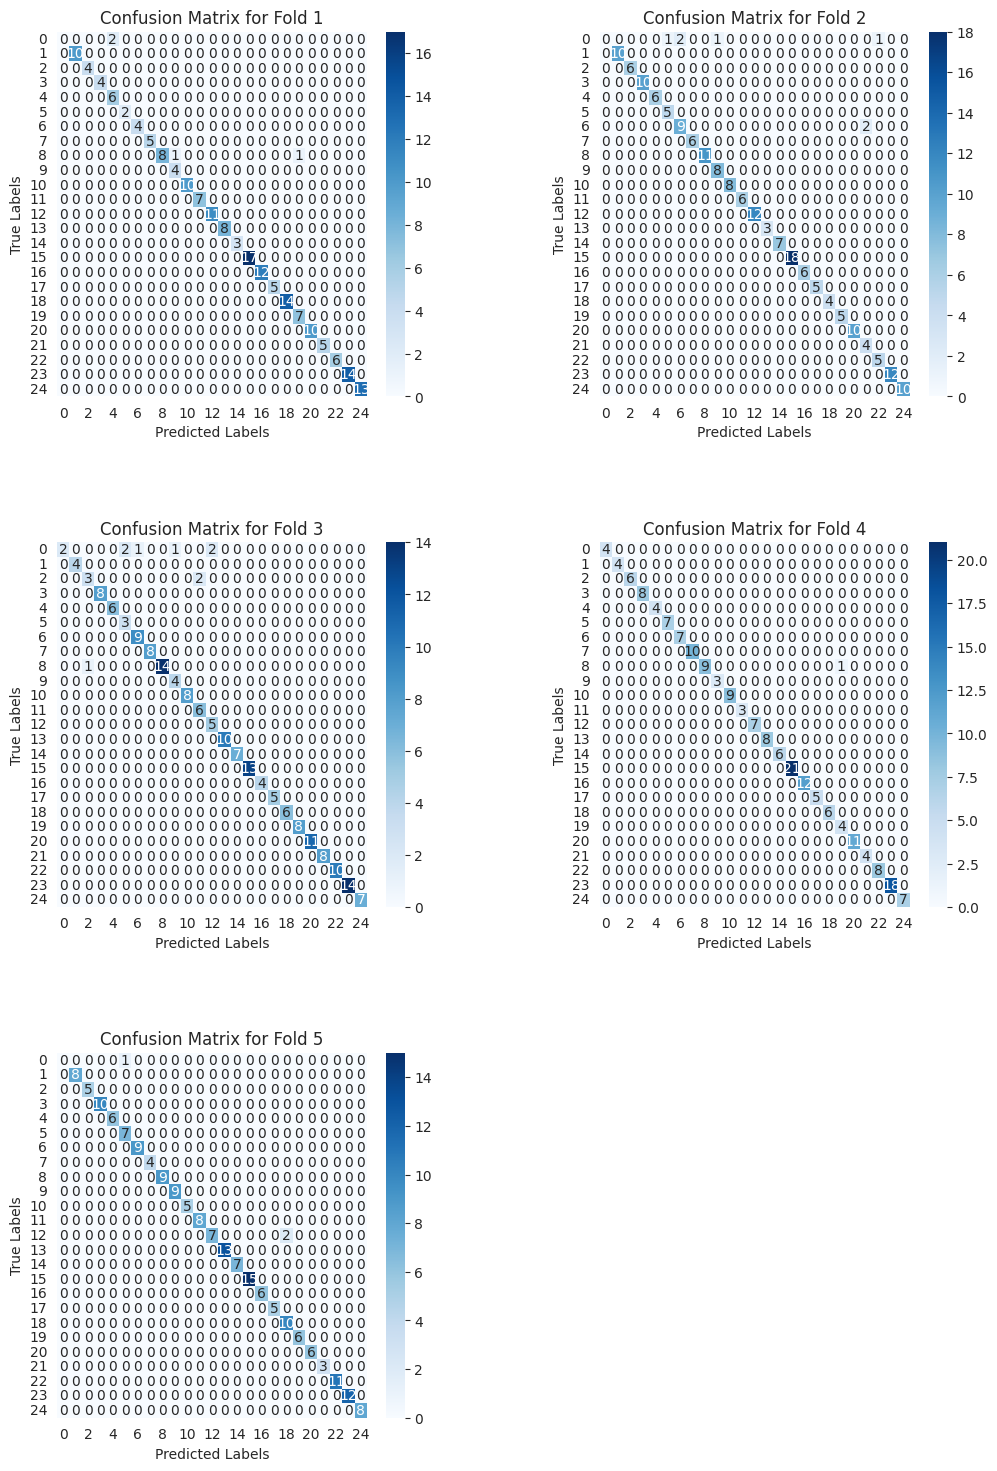

In [ ]:
# store each fold's performance metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

# prep confusion matrix plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# perform manual K-Fold CV
for i, (train_index, test_index) in enumerate(cv.split(features)):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = target[train_index], target[test_index]

    # train model
    model_tfidf.fit(
        X_train,
        y_train
    )

    # prediction
    y_pred = model_tfidf.predict(
        X_test
    )

    # calculate confusion matrix
    conf_matrix = confusion_matrix(
        y_true = y_test,
        y_pred = y_pred
    )

    # plot confusion matrix
    ax = axes.flatten()[i]
    sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {i + 1}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # calculate metrics
    accuracies.append(
        accuracy_score(y_test, y_pred)
    )
    precisions.append(
        precision_score(y_test, y_pred, average = 'weighted')
    )
    recalls.append(
        recall_score(y_test, y_pred, average = 'weighted')
    )
    f1_scores.append(
        f1_score(y_test, y_pred, average = 'weighted')
    )

# hiding any unused subplots
for j in range(i + 1, axes.size):
    axes.flatten()[j].axis('off')

plt.show()

In [ ]:
# calculate and print average performance metrics
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1_score = np.mean(f1_scores)

print(f"Average Validation Accuracy: {avg_accuracy * 100:.1f}%")
print(f"Average Validation Precision: {avg_precision * 100:.1f}%")
print(f"Average Validation Recall: {avg_recall * 100:.1f}%")
print(f"Average Validation F1 Score: {avg_f1_score * 100:.1f}%")

Average Validation Accuracy: 97.5%
Average Validation Precision: 97.1%
Average Validation Recall: 97.5%
Average Validation F1 Score: 97.0%


##### 5.1.2) One-vs-Rest Classifier, Word2Vec Vectorization

In [ ]:
# tokenize and preprocess the text
df['tokenized'] = df['Cleaned_Resume'].apply(
    lambda resume: simple_preprocess(
        doc = resume
    )
)

# train Word2Vec model
model = Word2Vec(
    sentences=df['tokenized'],
    vector_size=50,
    window=3,
    min_count=1,
    workers=4,
    sg=1
)

# define function to create a vector for a document
def document_vector(doc):
    """Generates a document vector by averaging the word vectors of the words in the document."""
    valid_words = [
        word for word in doc if word in model.wv.index_to_key
    ]
    if valid_words:
        return np.mean(model.wv[valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

# create document vectors for each resume
df['doc_vector'] = df['tokenized'].apply(
    lambda tokenized_resume: document_vector(
        doc = tokenized_resume
    )
)

# prepare data for modeling
X_word2vec = np.array(df['doc_vector'].tolist())
y = df['Category']

# encode target variable
label = LabelEncoder()
y_encoded = label.fit_transform(y)

# define CV procedure
cv = KFold(
    n_splits = 5,
    random_state = 21,
    shuffle = True
)

# define model
model_word_2_vec = OneVsRestClassifier(
    estimator = KNeighborsClassifier()
)

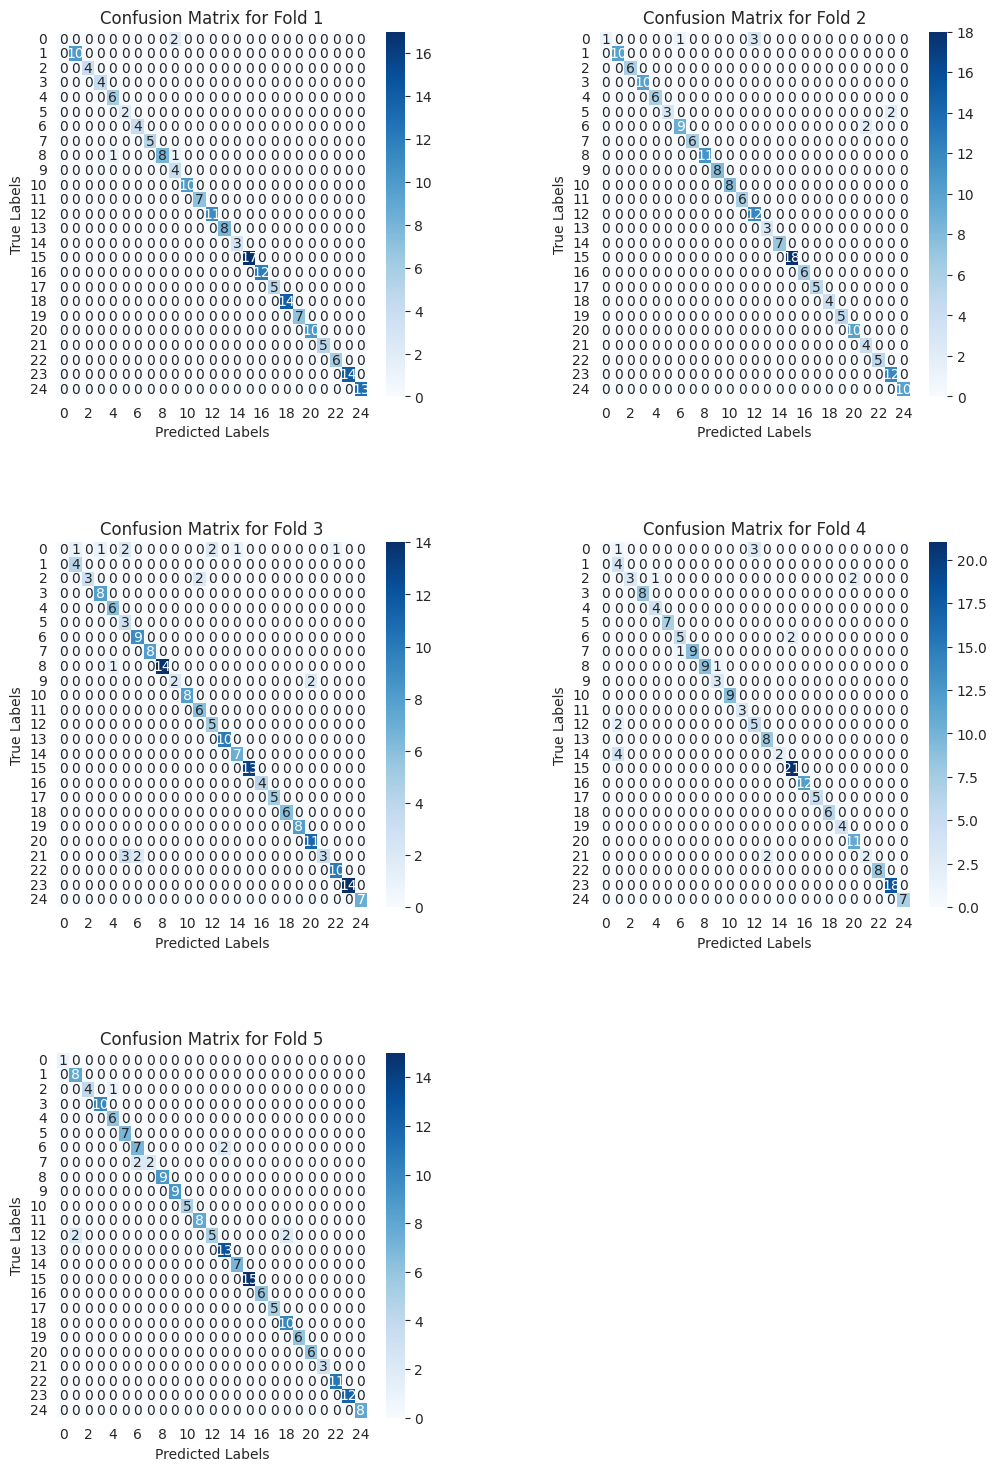

In [ ]:
# store each fold's performance metrics
accuracies, precisions, recalls, f1_scores = [], [], [], []

# prep confusion matrix plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# perform manual K-Fold CV
for i, (train_index, test_index) in enumerate(cv.split(X_word2vec)):
    X_train, X_test = X_word2vec[train_index], X_word2vec[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # train model
    model_word_2_vec.fit(X_train, y_train)

    # prediction
    y_pred = model_word_2_vec.predict(X_test)

    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # plot confusion matrix
    ax = axes.flatten()[i]
    sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {i + 1}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # calculate metrics
    accuracies.append(
        accuracy_score(y_test, y_pred)
    )
    precisions.append(
        precision_score(y_test, y_pred, average='weighted')
    )
    recalls.append(
        recall_score(y_test, y_pred, average='weighted')
    )
    f1_scores.append(
        f1_score(y_test, y_pred, average='weighted')
    )

# hiding any unused subplots and show plots
for j in range(i + 1, axes.size):
    axes.flatten()[j].axis('off')
plt.show()

In [ ]:
# calculate and print average performance metrics
print(f"Average Validation Accuracy: {np.mean(accuracies) * 100:.1f}%")
print(f"Average Validation Precision: {np.mean(precisions) * 100:.1f}%")
print(f"Average Validation Recall: {np.mean(recalls) * 100:.1f}%")
print(f"Average Validation F1 Score: {np.mean(f1_scores) * 100:.1f}%")

Average Validation Accuracy: 94.0%
Average Validation Precision: 94.1%
Average Validation Recall: 94.0%
Average Validation F1 Score: 93.1%


##### 5.1.3) One-vs-Rest Classifier, GloVe Vectorization

In [ ]:
# Tokenize and preprocess the text
df['tokenized'] = df['Cleaned_Resume'].apply(
    lambda resume: word_tokenize(
        text = resume
    )
)

# vectorize resumes using GloVe
df['Vec_Resume_Glove'] = df['Cleaned_Resume'].apply(
    lambda resume: vectorize_text(
        text = resume,
        model = model_glove
    )
)

In [ ]:
# prepare data for modeling
X_glove = np.array(df['Vec_Resume_Glove'].tolist())
y = df['Category']

# encode target variable
label = LabelEncoder()
y_encoded = label.fit_transform(
    y
)

# define model
model_glove_training = OneVsRestClassifier(
    estimator = KNeighborsClassifier()
)

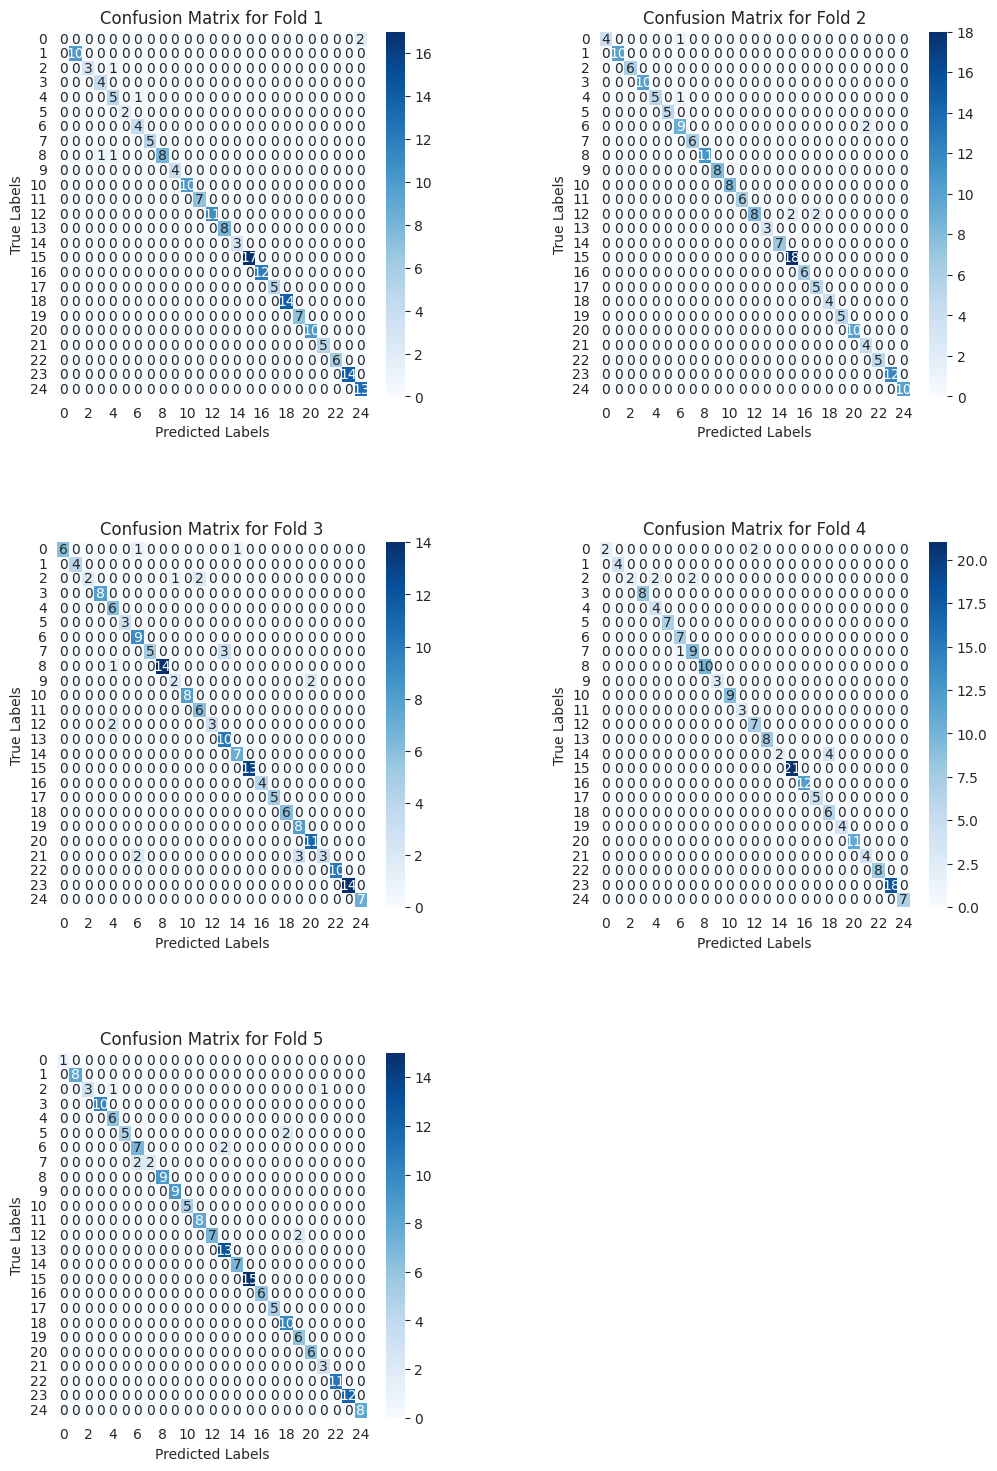

In [ ]:
# define CV procedure
cv = KFold(
    n_splits = 5,
    random_state = 21,
    shuffle = True
)

# store each fold's performance metrics
accuracies, precisions, recalls, f1_scores = [], [], [], []

# prep confusion matrix plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# perform manual K-Fold CV
for i, (train_index, test_index) in enumerate(cv.split(X_glove)):
    X_train, X_test = X_glove[train_index], X_glove[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # train model
    model_glove_training.fit(X_train, y_train)

    # prediction
    y_pred = model_glove_training.predict(X_test)

    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # plot confusion matrix
    ax = axes.flatten()[i]
    sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {i + 1}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# hiding any unused subplots; showing subplots
for j in range(i + 1, axes.size):
    axes.flatten()[j].axis('off')
plt.show()

In [ ]:
# calculate and print average performance metrics
print(f"Average Validation Accuracy: {np.mean(accuracies) * 100:.1f}%")
print(f"Average Validation Precision: {np.mean(precisions) * 100:.1f}%")
print(f"Average Validation Recall: {np.mean(recalls) * 100:.1f}%")
print(f"Average Validation F1 Score: {np.mean(f1_scores) * 100:.1f}%")

Average Validation Accuracy: 94.5%
Average Validation Precision: 95.4%
Average Validation Recall: 94.5%
Average Validation F1 Score: 94.0%


#### 5.2) Classification via MLP

In [ ]:
# define hyperparameters
MLP_BATCH_SIZE = 64
MLP_HIDDEN_DIMS_LIST = [128]
MLP_DROPOUT = 0.3
MLP_LEARNING_RATE = 0.001
MLP_NUM_EPOCHS = 100

In [ ]:
# getting device for trianing MLP
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"Device: \"{device}\".")

Device: "cpu".


##### 5.2.0) Define Reusable Functions to Make MLP, Train an MLP using SoftMax

In [ ]:
def make_mlp(
    input_dim: int,
    hidden_dims: List[int],
    output_dim: int,
    hidden_activation: nn.Module = nn.ReLU,
    dropout: float = 0.0
) -> nn.Sequential:
    """
    Purpose: Constructs an MLP model dynamically based on specified parameters.
    :param input_dim: int representing dimensionality of input features.
    :param hidden_dims: List[int] representing sizes of hidden layers.
    :param output_dim: int representing the size of the output layer.
    :param hidden_activation: nn.Module representing the hidden layer activation.
    :param dropout: Dropout rate for regularization between layers.
    :return: nn.Sequential representing a model consisting of the configured layers.
    """
    seq_list = []

    if len(hidden_dims) > 0:
        seq_list.append(nn.Linear(input_dim, hidden_dims[0]))
        seq_list.append(hidden_activation())

        if dropout > 0.0:
            seq_list.append(nn.Dropout(dropout))

        for i in range(1, len(hidden_dims)):
            seq_list.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
            seq_list.append(hidden_activation())

            if dropout > 0.0:
                seq_list.append(nn.Dropout(dropout))

        seq_list.append(nn.Linear(hidden_dims[-1], output_dim))
    else:
        seq_list.append(nn.Linear(input_dim, output_dim))

    mlp = nn.Sequential(*seq_list)
    return mlp

In [ ]:
def train_and_validate_mlp(
    mlp_model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: optim.Optimizer,
    loss_function: nn.modules.loss._Loss,
    device: torch.device = torch.device('cpu'),
    epochs: int = 25
) -> Tuple:
    """
    Purpose: Trains and validates an MLP model over a specified number of epochs,
        computing training and validation metrics.
    :param mlp_model: The MLP neural network model to be trained and validated.
    :param train_loader: DataLoader for the training dataset.
    :param val_loader: DataLoader for the validation dataset.
    :param optimizer: optim.Optimizer algorithm used for gradient descent.
    :param loss_function: The loss function used to calculate the difference between
        the predicted and actual values.
    :param device: The device (CPU or GPU) on which the model and data are loaded for training.
    :param epochs: The total number of passes through the entire training dataset.
    :return: Tuple containing a list of train and validation true and predicted labels
    """
    # ensure model is on device
    mlp_model = mlp_model.to(device)

    # initialize metrics tracking
    best_train_accuracy = 0
    best_avg_train_loss = float('inf')
    best_avg_val_loss = float('inf')
    best_avg_val_loss_epoch_idx = -1
    best_val_accuracy = 0
    best_train_preds = []
    best_train_true = []

    # lists to store loss per epoch
    train_losses_list = []
    validation_losses_list = []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        epoch_idx = epoch + 1
        #print(f"Beginning epoch {epoch_idx}...")

        # ensure model is in train mode
        mlp_model.train()

        total_train_loss = 0
        correct_train_predictions = 0
        total_train_predictions = 0
        all_train_preds = []
        all_train_true = []

        for X_batch, y_batch in train_loader:

            # move tensors to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # reset gradients to 0 before starting backpropagation
            optimizer.zero_grad()

            # compute model predictions for the batch
            y_pred = mlp_model(
                X_batch
            )

            # computing loss for train batch
            train_batch_loss = loss_function(
                y_pred,
                y_batch
            )

            # backpropagate the batch loss and compute the gradients
            train_batch_loss.backward()

            # perform single optimization step by updating model's parameters based on gradients
            optimizer.step()

            # accumulating the epoch's total train loss
            total_train_loss += train_batch_loss.item()

            # calculate number of correct predictions
            predictions = torch.argmax(y_pred, dim = 1)
            correct_train_predictions += (predictions == y_batch).sum().item()

            total_train_predictions += y_batch.size(0)
            all_train_preds.extend(predictions.cpu().numpy())
            all_train_true.extend(y_batch.cpu().numpy())

        # tracking best train accuracy
        train_accuracy = accuracy_score(
            y_true = all_train_true,
            y_pred = all_train_preds
        )
        #train_accuracy = 100 * correct_train_predictions / total_train_predictions
        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy
            best_train_preds = all_train_preds.copy()
            best_train_true = all_train_true.copy()

        # calculate and print average train loss and accuracy
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses_list.append(avg_train_loss)
        if avg_train_loss < best_avg_train_loss:
            best_avg_train_loss = avg_train_loss
            #best_train_preds = all_train_preds.copy()
            #best_train_true = all_train_true.copy()

        # ------------------------------------------------------------------------------------------
        # BEGIN MODEL VALIDATION

        # switch model to evaluation mode
        mlp_model.eval()
        total_val_loss = 0
        correct_predictions = 0
        all_preds = []
        all_true = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                # move tensors to device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                # compute model's predictions for the validation data
                y_pred = mlp_model(
                    X_batch
                )

                # computing validation loss
                val_batch_loss = loss_function(
                    y_pred,
                    y_batch
                )

                # accumulating the epoch's total validation loss
                total_val_loss += val_batch_loss.item()

                # calculate number of correct predictions
                predictions = torch.argmax(y_pred, dim = 1)
                correct_predictions += (predictions == y_batch).sum().item()
                all_preds.extend(predictions.cpu().numpy())
                all_true.extend(y_batch.cpu().numpy())

        # calculate and print epoch's validation metrics
        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses_list.append(avg_val_loss)

        val_accuracy = accuracy_score(
            y_true = all_true,
            y_pred = all_preds
        )

        # tracking best val accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_val_preds = all_preds.copy()
            best_val_true = all_true.copy()

        # check to update best validation performance
        if avg_val_loss < best_avg_val_loss:
            best_avg_val_loss = avg_val_loss
            best_avg_val_loss_epoch_idx = epoch_idx
            #best_val_preds = all_preds.copy()
            #best_val_true = all_true.copy()

    # calculate confusion matrix for the best epoch
    conf_matrix = confusion_matrix(
        y_true = best_val_true,
        y_pred = best_val_preds
    )
    # plot confusion matrix
    plt.figure(
        figsize = (8, 6)
    )
    sns.heatmap(
        data = conf_matrix,
        annot = True,
        fmt = 'd',
        cmap = 'Blues'
    )
    plt.title(f'Confusion Matrix for Lowest Validation Loss (Epoch {best_avg_val_loss_epoch_idx})')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # plot training and validation losses
    plt.figure(
        figsize = (8, 4)
    )
    # Since epochs start from 1 and go up to 'epochs', we plot against epoch numbers directly
    plt.plot(
        range(1, epochs + 1),
        train_losses_list,
        label = 'Avg Training Loss'
        )
    plt.plot(
        range(1, epochs + 1),
        validation_losses_list,
        label = 'Avg Validation Loss'
    )
    plt.title('Training and Validation Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.xlim(
        left = 0.1,
        right=epochs + 0.1
    )
    plt.xticks(range(1, epochs + 1), rotation = 45, fontsize = 6)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return (best_train_true, best_train_preds, best_val_true, best_val_preds)

##### 5.2.1) MLP Classifier, TF-IDF Vectorization

Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.05it/s]


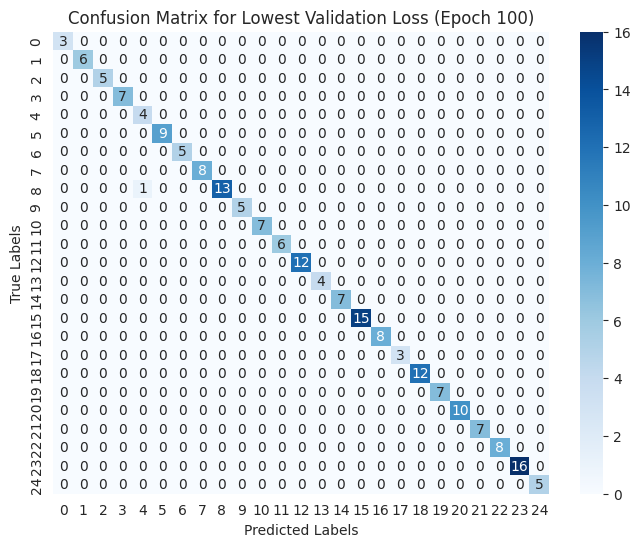

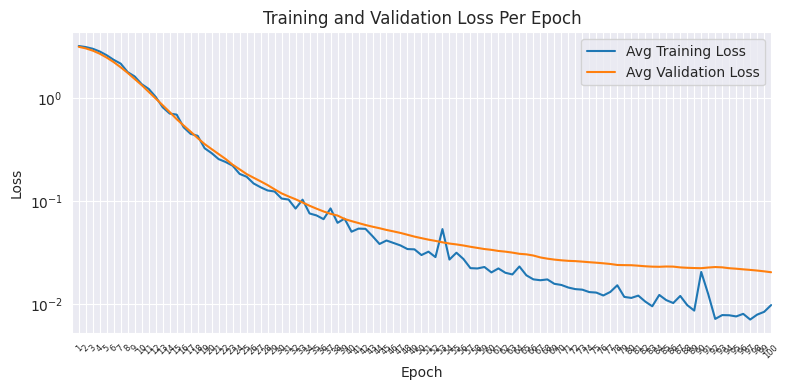

Epochs: 100%|██████████| 100/100 [00:04<00:00, 20.64it/s]


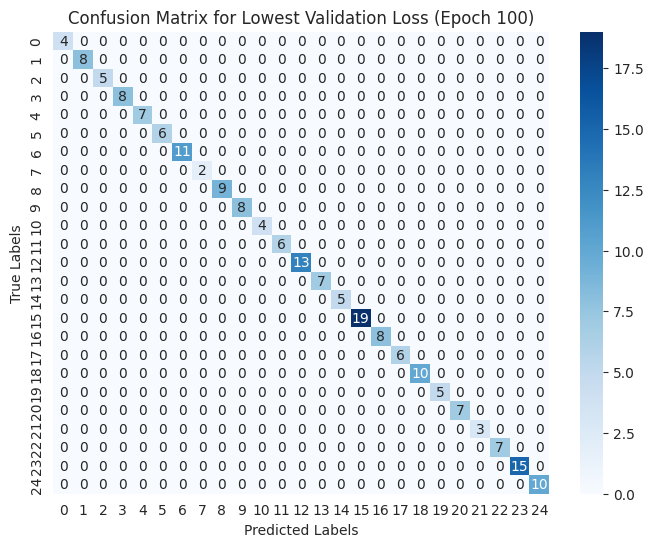

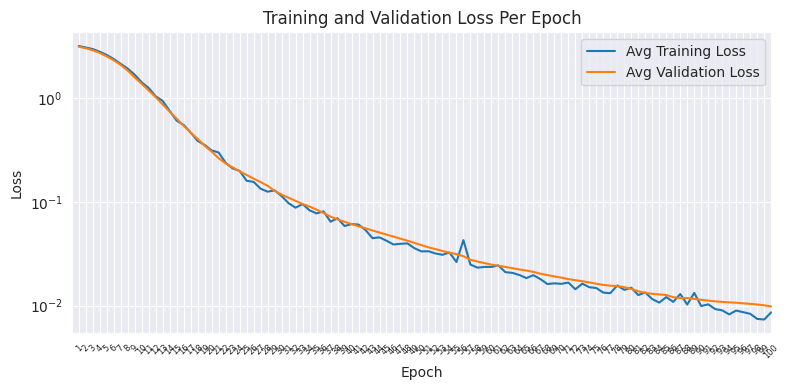

Epochs: 100%|██████████| 100/100 [00:04<00:00, 22.01it/s]


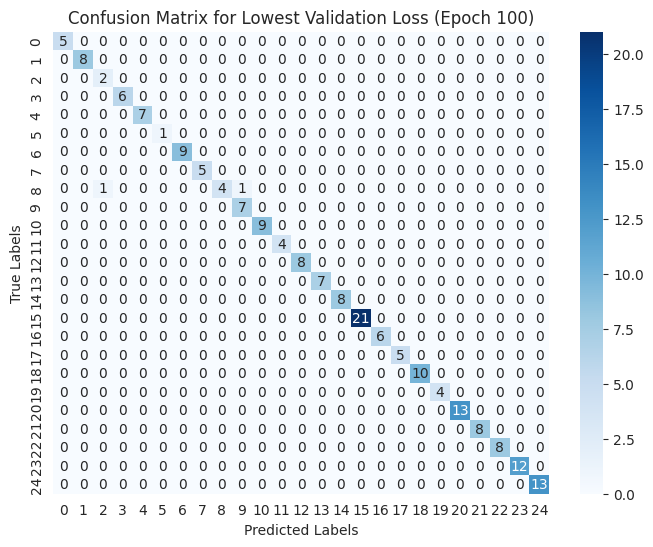

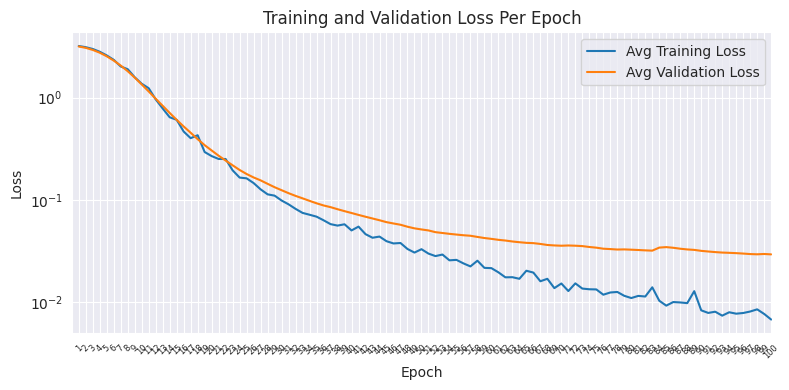

Epochs: 100%|██████████| 100/100 [00:05<00:00, 16.81it/s]


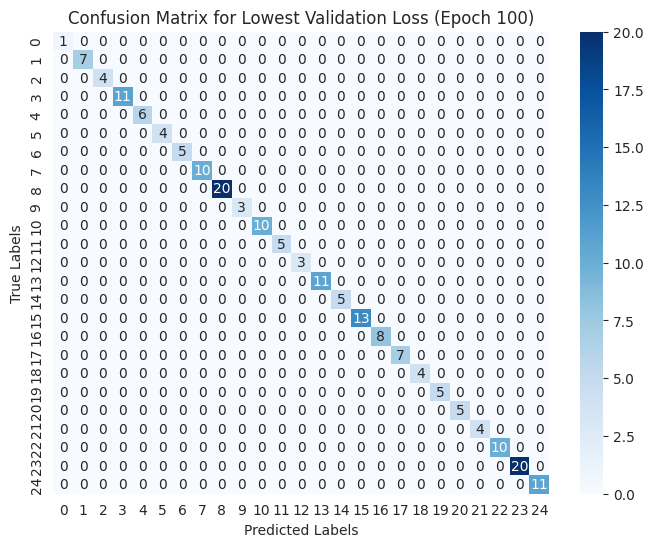

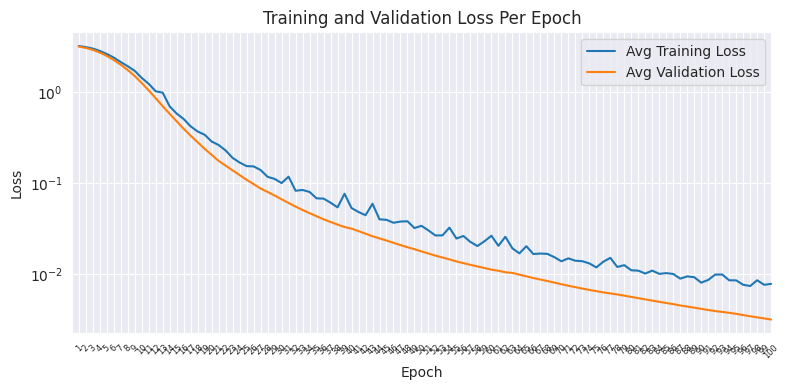

Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


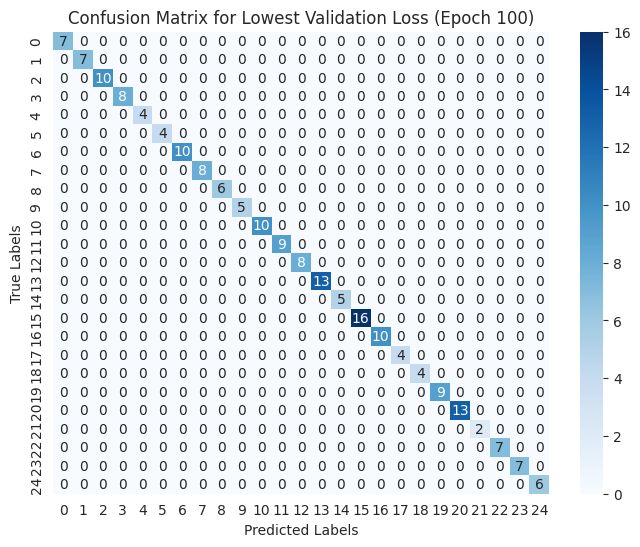

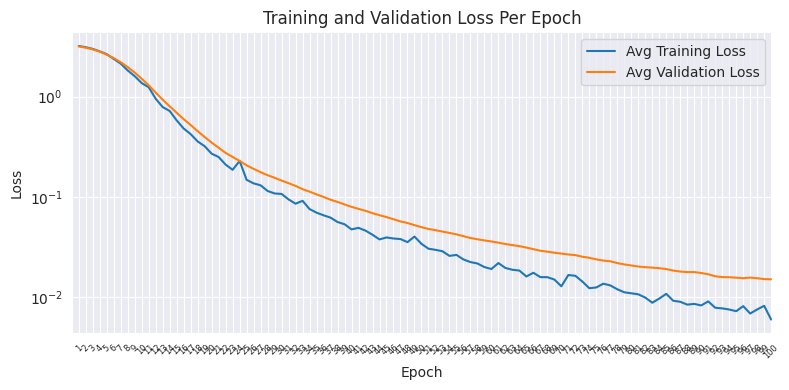

In [ ]:
# vectorizing cleaned columns
text = df['Cleaned_Resume'].values
target = df['Target'].values

# initialize label encoder and transform target labels
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=False,
    stop_words='english',
    max_features=500
)
tfidf_vectorizer.fit(raw_documents=text)
features_train = tfidf_vectorizer.transform(raw_documents=text)

# define K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# metrics storage
train_accuracies = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# initializing the list to collect misclassified resumes
misclassified_resumes = []

# K-Fold Cross Validation loop
for train_index, test_index in kf.split(features_train):
    # splitting data into folds
    X_train_fold, X_test_fold = features_train[train_index], features_train[test_index]
    y_train_fold, y_test_fold = target_encoded[train_index], target_encoded[test_index]

    # convert to tensors
    X_train_tensor = torch.tensor(X_train_fold.toarray(), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_fold.toarray(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test_fold, dtype=torch.long)

    # DataLoader for training and validation sets
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor), batch_size=MLP_BATCH_SIZE, shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(X_test_tensor, y_test_tensor), batch_size=MLP_BATCH_SIZE, shuffle=False
    )

    # model initialization
    mlp_model = make_mlp(
        input_dim=X_train_fold.shape[1],
        hidden_dims=MLP_HIDDEN_DIMS_LIST,
        output_dim=len(label_encoder.classes_),
        dropout=MLP_DROPOUT
    )
    mlp_model.to(device)

    # loss function and optimizer
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=MLP_LEARNING_RATE)

    # train and validate model
    best_train_true, best_train_preds, best_val_true, best_val_preds = train_and_validate_mlp(
        mlp_model=mlp_model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        loss_function=loss_function,
        device=device,
        epochs=MLP_NUM_EPOCHS
    )

    # checking for misclassified resumes
    for i, (true, pred) in enumerate(zip(best_val_true, best_val_preds)):
        if true != pred:
            # getting original index from dataset
            misclassified_idx = test_index[i]
            misclassified_resumes.append(
                {
                    'Text': df.loc[misclassified_idx, 'Cleaned_Resume'],
                    'True_Label': label_encoder.inverse_transform([true])[0],
                    'Pred_Label': label_encoder.inverse_transform([pred])[0]
                }
            )

    # calculate and store metrics
    train_accuracy = accuracy_score(best_train_true, best_train_preds)
    val_accuracy = accuracy_score(best_val_true, best_val_preds)
    val_precision = precision_score(best_val_true, best_val_preds, average='weighted')
    val_recall = recall_score(best_val_true, best_val_preds, average='weighted')
    val_f1 = f1_score(best_val_true, best_val_preds, average='weighted')

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

In [ ]:
# print average results from cross-validation
print("Average training accuracy:", np.mean(train_accuracies))
print("Average validation accuracy:", np.mean(val_accuracies))
print("Average validation precision:", np.mean(val_precisions))
print("Average validation recall:", np.mean(val_recalls))
print("Average validation F1-score:", np.mean(val_f1_scores))

Average training accuracy: 1.0
Average validation accuracy: 0.9968803972366149
Average validation precision: 0.9975650816781808
Average validation recall: 0.9968803972366149
Average validation F1-score: 0.9968493331414315


In [ ]:
# print misclassified resumes
for i, misclassified in enumerate(misclassified_resumes, 1):
    text = misclassified['Text']
    pred_idx = misclassified['Pred_Label']
    true_idx = misclassified['True_Label']

    print("Misclassified Resume:")
    print(f"\t Text: \"{text}\"")
    print(f"\t\t- y_pred = {pred_idx}")
    print(f"\t\t- y_true = {true_idx}")

Misclassified Resume:
	 Text: "core skill â¢ project program management â¢ agile scrum management â¢ risk client management â¢ process improvement â¢ proposalsrfe â¢ selenium â¢ rally ibm td platform â¢ python â¢ devops devsecops â¢ safe agile craft â¢ delivery test management â¢ project program finance â¢ profit maximization â¢ internal external audit â¢ software testing quality assurance â¢ visual basic 60 â¢ mssql server oracle 88i â¢ conformiq â¢ hp qc qtp â¢ crystal report 85 linguistic skill english hindi marathi tulu education detail january 2013 harvard january 2004 software engineering aptech january 2001 bachelor commerce commerce mumbai maharashtra mumbai university project manager project manager att skill detail testing exprience 63 month oracle exprience 6 month sql exprience 6 month audit exprience 6 month client management exprience 6 monthscompany detail company att description thunderbird program onestoptestshop catering atts enterprisewide busines

##### 5.2.2) MLP Classifier, Word2Vec Vectorization

In [ ]:
# tokenize and preprocess the text
df['tokenized'] = df['Cleaned_Resume'].apply(
    lambda resume: simple_preprocess(
        doc = resume
    )
)

# train Word2Vec model
model = Word2Vec(
    sentences = df['tokenized'],
    vector_size = 50,
    window = 3,
    min_count = 1,
    workers = 4,
    sg = 1
)

# define function to create a vector for a document
def document_vector(
    doc: List[str],
    vector_size: int,
    model
) -> np.ndarray:
    """
    Purpose: Generates a document vector by averaging the word vectors of the words in the document.
    :param doc: List[str] representing tokenized words in a document.
    :param vector_size: int representing dimensionality of the word vectors in the model.
    :param model: gensim.models.KeyedVectors representing the pre-trained Word2Vec model.
    :return: np.ndarray representing the averaged vector of the document's words.
    """
    # remove out-of-vocabulary words
    valid_words = [
       word for word in doc if word in model.wv.index_to_key
    ]
    if valid_words:
        return np.mean(
            model.wv[valid_words],
            axis = 0
        )
    else:
        return np.zeros(vector_size)

# create document vectors for each resume
df['doc_vector'] = df['tokenized'].apply(
    lambda tokenized_resume: document_vector(
        doc = tokenized_resume,
        model = model,
        vector_size=50
    )
)

# prepare data for modeling
X_word2vec = np.array(
    df['doc_vector'].tolist()
)
y = df['Category']

# encode target variable
label = LabelEncoder()
y_encoded = label.fit_transform(
    y
)

Epochs: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


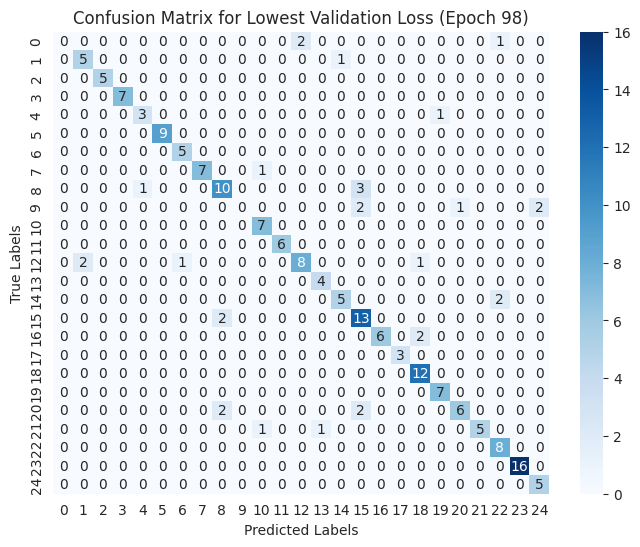

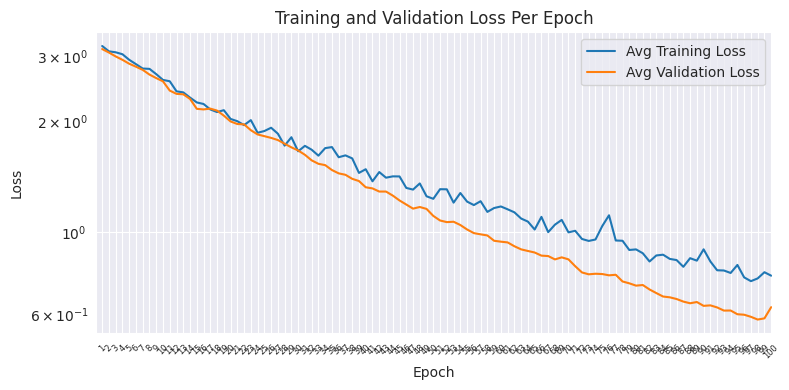

Epochs: 100%|██████████| 100/100 [00:05<00:00, 19.45it/s]


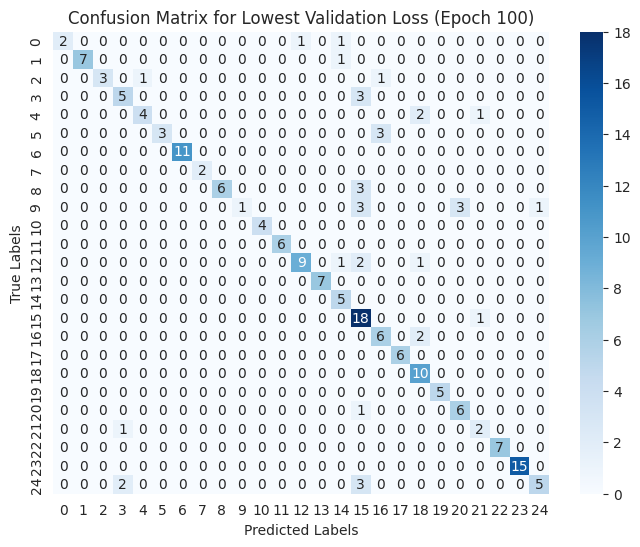

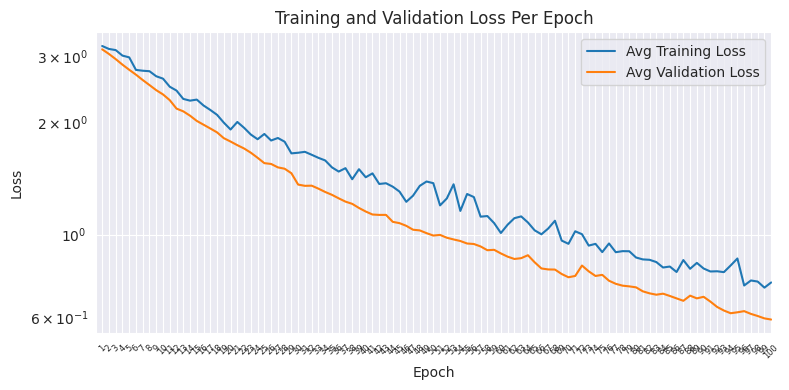

Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.29it/s]


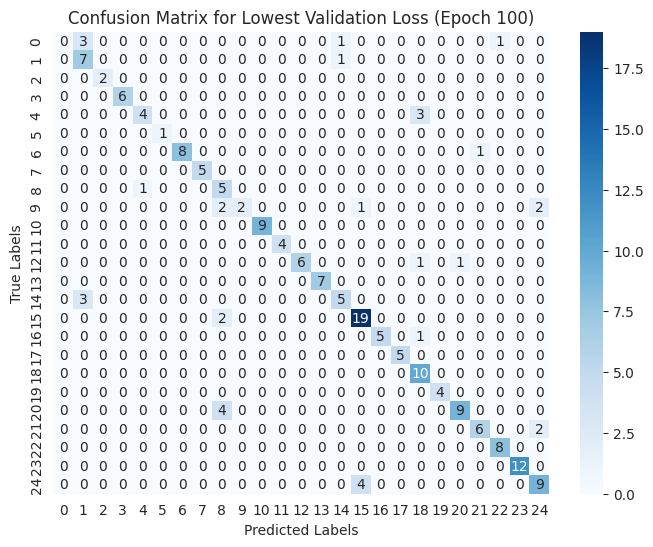

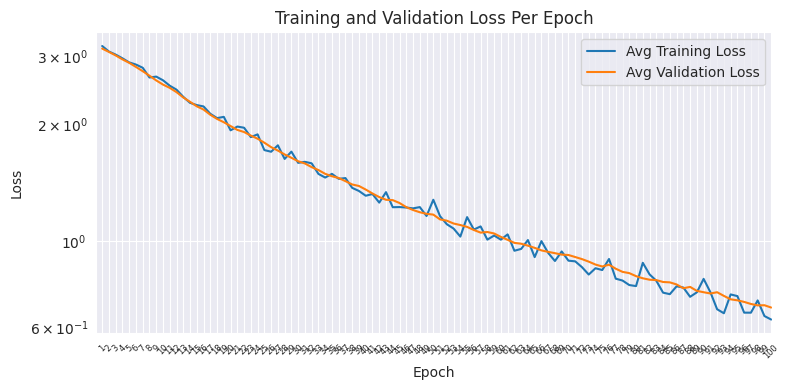

Epochs: 100%|██████████| 100/100 [00:03<00:00, 26.66it/s]


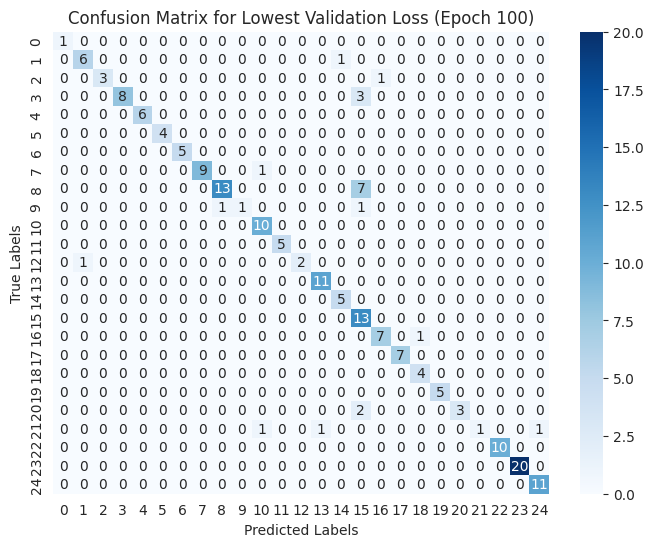

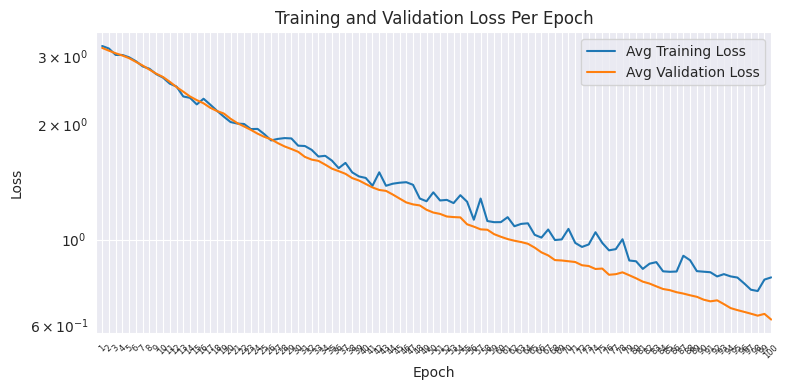

Epochs: 100%|██████████| 100/100 [00:04<00:00, 20.42it/s]


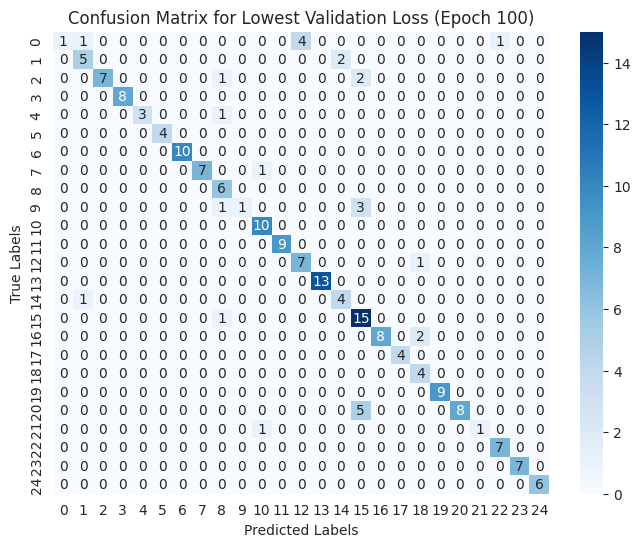

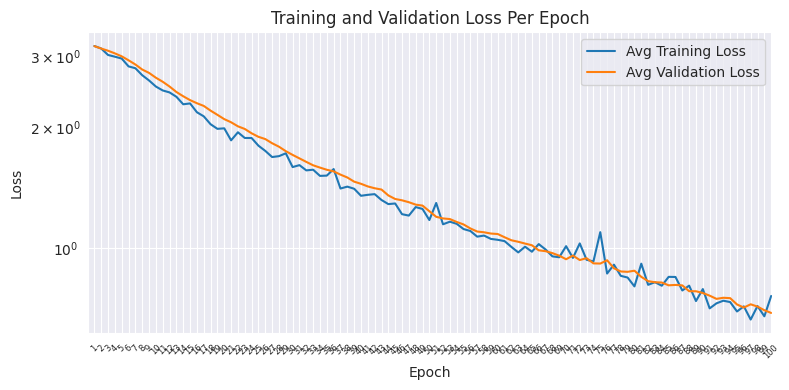

In [ ]:
# initialize cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# metrics storage
train_accuracies = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# initializing the list to collect misclassified resumes
misclassified_resumes = []

# K-Fold Cross Validation loop
for train_index, test_index in kf.split(X_word2vec):
    X_train, X_val = X_word2vec[train_index], X_word2vec[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    # convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # DataLoader for training and validation sets
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=MLP_BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=MLP_BATCH_SIZE, shuffle=False)

    # initialize model
    mlp_model = make_mlp(input_dim=50, hidden_dims=MLP_HIDDEN_DIMS_LIST, output_dim=len(set(y_encoded)), dropout=MLP_DROPOUT)
    mlp_model.to(device)

    # loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=MLP_LEARNING_RATE)

    # train and validate model
    _, _, best_val_true, best_val_preds = train_and_validate_mlp(
        mlp_model=mlp_model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        loss_function=loss_function,
        device=device,
        epochs=MLP_NUM_EPOCHS
    )

    # checking for misclassified resumes
    for i, (true, pred) in enumerate(zip(best_val_true, best_val_preds)):
        if true != pred:
            # getting original index from dataset
            misclassified_idx = test_index[i]
            misclassified_resumes.append(
                {
                    'Text': df.loc[misclassified_idx, 'Cleaned_Resume'],
                    'True_Label': label_encoder.inverse_transform([true])[0],
                    'Pred_Label': label_encoder.inverse_transform([pred])[0]
                }
            )

    # metrics calculation
    val_accuracy = accuracy_score(y_true=best_val_true, y_pred=best_val_preds)
    val_precision = precision_score(y_true=best_val_true, y_pred=best_val_preds, average='weighted')
    val_recall = recall_score(y_true=best_val_true, y_pred=best_val_preds, average='weighted')
    val_f1 = f1_score(y_true=best_val_true, y_pred=best_val_preds, average='weighted')

    # store metrics
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

In [ ]:
# output average results
print("Average Validation Accuracy: {:.2f}%".format(np.mean(val_accuracies) * 100))
print("Average Validation Precision: {:.2f}%".format(np.mean(val_precisions) * 100))
print("Average Validation Recall: {:.2f}%".format(np.mean(val_recalls) * 100))
print("Average Validation F1 Score: {:.2f}%".format(np.mean(val_f1_scores) * 100))

Average Validation Accuracy: 84.10%
Average Validation Precision: 86.59%
Average Validation Recall: 84.10%
Average Validation F1 Score: 83.11%


In [ ]:
# print misclassified resumes
for i, misclassified in enumerate(misclassified_resumes, 1):
    text = misclassified['Text']
    pred_idx = misclassified['Pred_Label']
    true_idx = misclassified['True_Label']

    print("Misclassified Resume:")
    print(f"\t Text: \"{text}\"")
    print(f"\t\t- y_pred = {pred_idx}")
    print(f"\t\t- y_true = {true_idx}")

Misclassified Resume:
	 Text: "training special education certificate course education detail july 2016 october 2018 msc psychology specialization organizational behaviour malappuram kerala calicut university july 2013 march 2016 bsc psychology thrissur prajyoti niketan college hr skill detail company detail company description done 30 day internship hr department foster hot bread kinfra malappuram kerala also done 60 day internship santhwana institute counselling psychotherapy cochin kerala counsellor"
		- y_pred = 1
		- y_true = 12
Misclassified Resume:
	 Text: "skill â¢ window xp m office word excel lookup pivot table basic function power point â¢ saral payment package payroll software â¢ internet applicationseducation detail january 2006 bachelor hospitality management international hospitality management queen margaret university edinburg january 2006 diploma hotel management international institute hotel management hr skill detail hr management exprience le 1 year monthscompan

##### 5.2.3) MLP Classifier, GloVe Vectorization

In [ ]:
# tokenize and preprocess the text
df['tokenized'] = df['Cleaned_Resume'].apply(
    lambda resume: word_tokenize(text=resume)
)

# vectorize resumes using GloVe
df['Vec_Resume_Glove'] = df['Cleaned_Resume'].apply(
    lambda resume: vectorize_text(text=resume, model=model_glove)
)

# prepare data for modeling
X_glove = np.array(df['Vec_Resume_Glove'].tolist())
y = df['Category']

# encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


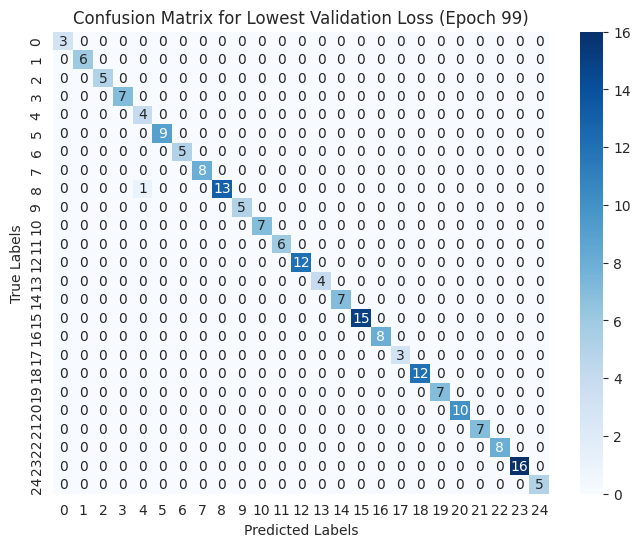

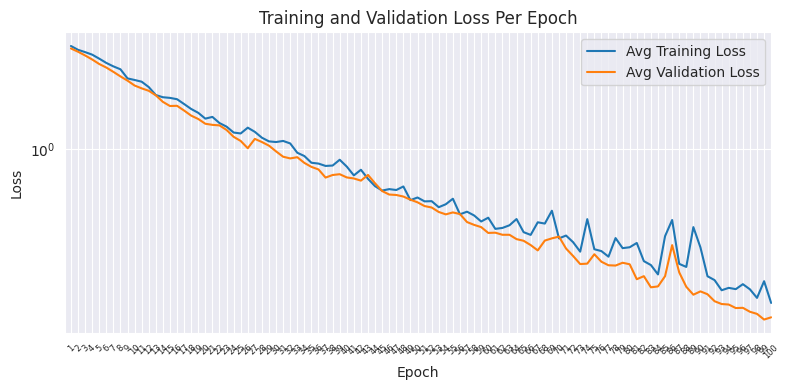

Epochs: 100%|██████████| 100/100 [00:04<00:00, 22.84it/s]


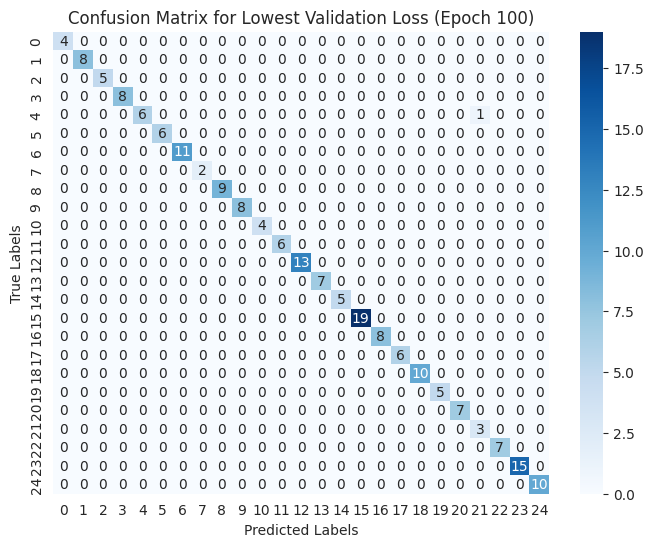

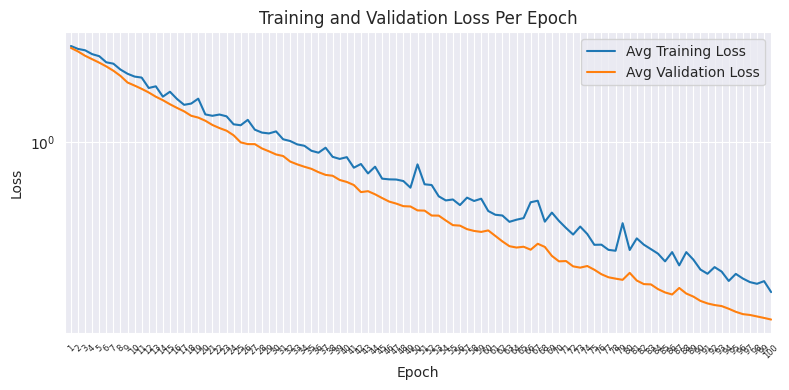

Epochs: 100%|██████████| 100/100 [00:04<00:00, 21.08it/s]


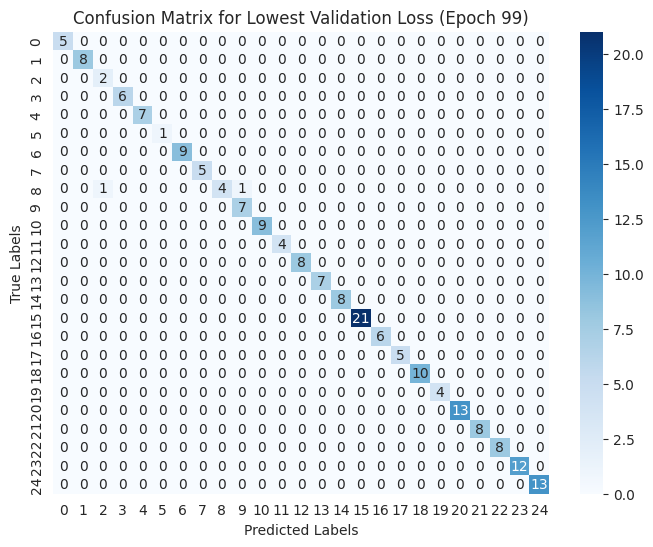

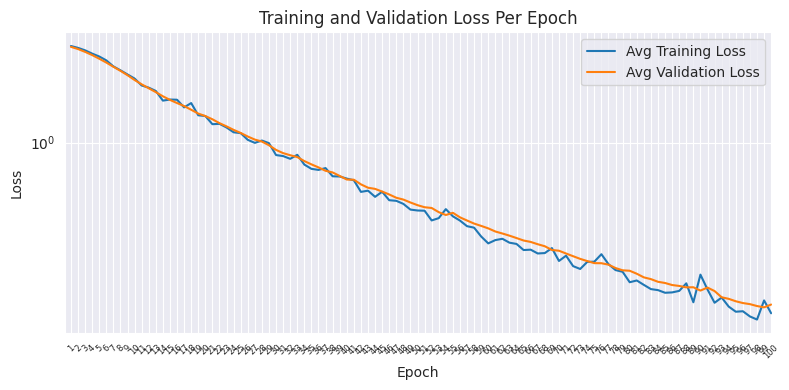

Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.87it/s]


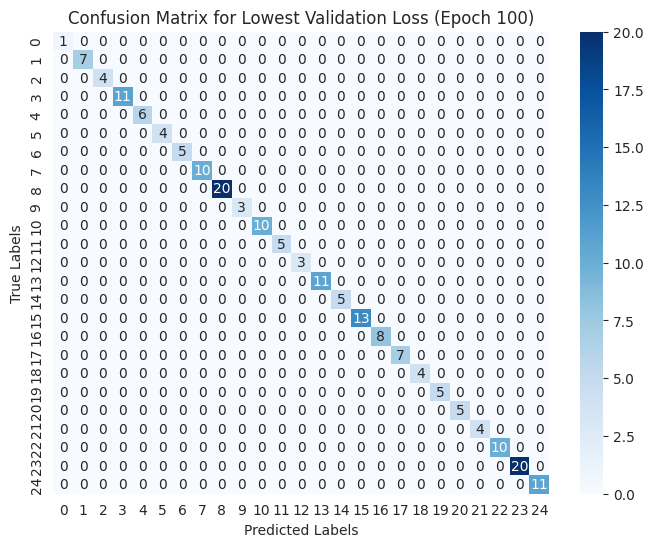

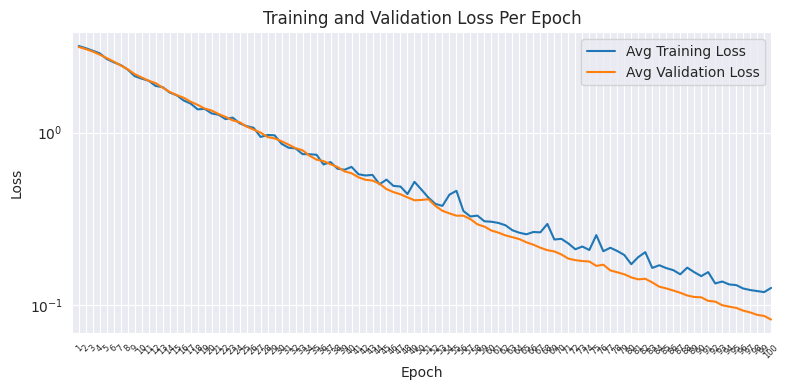

Epochs: 100%|██████████| 100/100 [00:04<00:00, 22.21it/s]


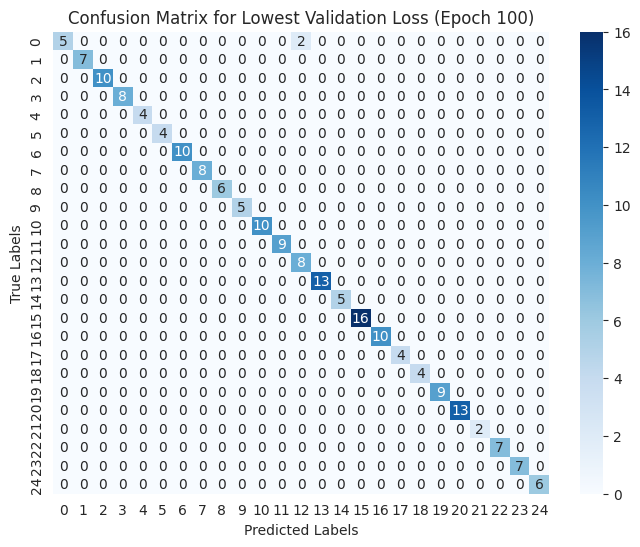

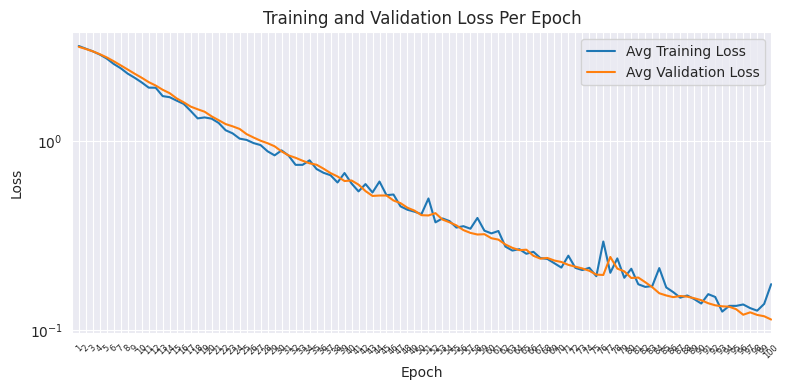

In [ ]:
# initialize cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# metrics storage
train_accuracies = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# initializing the list to collect misclassified resumes
misclassified_resumes = []

# K-Fold Cross Validation loop
for train_index, test_index in kf.split(X_glove):
    X_train, X_val = X_glove[train_index], X_glove[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    # convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # DataLoader for training and validation sets
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=MLP_BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=MLP_BATCH_SIZE, shuffle=False)

    # initialize model
    mlp_model = make_mlp(input_dim=X_train.shape[1], hidden_dims=MLP_HIDDEN_DIMS_LIST, output_dim=len(set(y_encoded)), dropout=MLP_DROPOUT)
    mlp_model.to(device)

    # loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=MLP_LEARNING_RATE)

    # train and validate model
    _, _, best_val_true, best_val_preds = train_and_validate_mlp(
        mlp_model=mlp_model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        loss_function=loss_function,
        device=device,
        epochs=MLP_NUM_EPOCHS
    )

    # checking for misclassified resumes
    for i, (true, pred) in enumerate(zip(best_val_true, best_val_preds)):
        if true != pred:
            # getting original index from dataset
            misclassified_idx = test_index[i]
            misclassified_resumes.append(
                {
                    'Text': df.loc[misclassified_idx, 'Cleaned_Resume'],
                    'True_Label': label_encoder.inverse_transform([true])[0],
                    'Pred_Label': label_encoder.inverse_transform([pred])[0]
                }
            )

    # metrics calculation
    val_accuracy = accuracy_score(y_true=best_val_true, y_pred=best_val_preds)
    val_precision = precision_score(y_true=best_val_true, y_pred=best_val_preds, average='weighted')
    val_recall = recall_score(y_true=best_val_true, y_pred=best_val_preds, average='weighted')
    val_f1 = f1_score(y_true=best_val_true, y_pred=best_val_preds, average='weighted')

    # store metrics
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

In [ ]:
# output average results
print("Average Validation Accuracy: {:.2f}%".format(np.mean(val_accuracies) * 100))
print("Average Validation Precision: {:.2f}%".format(np.mean(val_precisions) * 100))
print("Average Validation Recall: {:.2f}%".format(np.mean(val_recalls) * 100))
print("Average Validation F1 Score: {:.2f}%".format(np.mean(val_f1_scores) * 100))

Average Validation Accuracy: 99.38%
Average Validation Precision: 99.51%
Average Validation Recall: 99.38%
Average Validation F1 Score: 99.37%


In [ ]:
# print misclassified resumes
for i, misclassified in enumerate(misclassified_resumes, 1):
    text = misclassified['Text']
    pred_idx = misclassified['Pred_Label']
    true_idx = misclassified['True_Label']

    print("Misclassified Resume:")
    print(f"\t Text: \"{text}\"")
    print(f"\t\t- y_pred = {pred_idx}")
    print(f"\t\t- y_true = {true_idx}")

Misclassified Resume:
	 Text: "core skill â¢ project program management â¢ agile scrum management â¢ risk client management â¢ process improvement â¢ proposalsrfe â¢ selenium â¢ rally ibm td platform â¢ python â¢ devops devsecops â¢ safe agile craft â¢ delivery test management â¢ project program finance â¢ profit maximization â¢ internal external audit â¢ software testing quality assurance â¢ visual basic 60 â¢ mssql server oracle 88i â¢ conformiq â¢ hp qc qtp â¢ crystal report 85 linguistic skill english hindi marathi tulu education detail january 2013 harvard january 2004 software engineering aptech january 2001 bachelor commerce commerce mumbai maharashtra mumbai university project manager project manager att skill detail testing exprience 63 month oracle exprience 6 month sql exprience 6 month audit exprience 6 month client management exprience 6 monthscompany detail company att description thunderbird program onestoptestshop catering atts enterprisewide busines

#### 5.3) Classification via SVM

##### 5.3.1) SVM Classifier, TF-IDF Vectorization

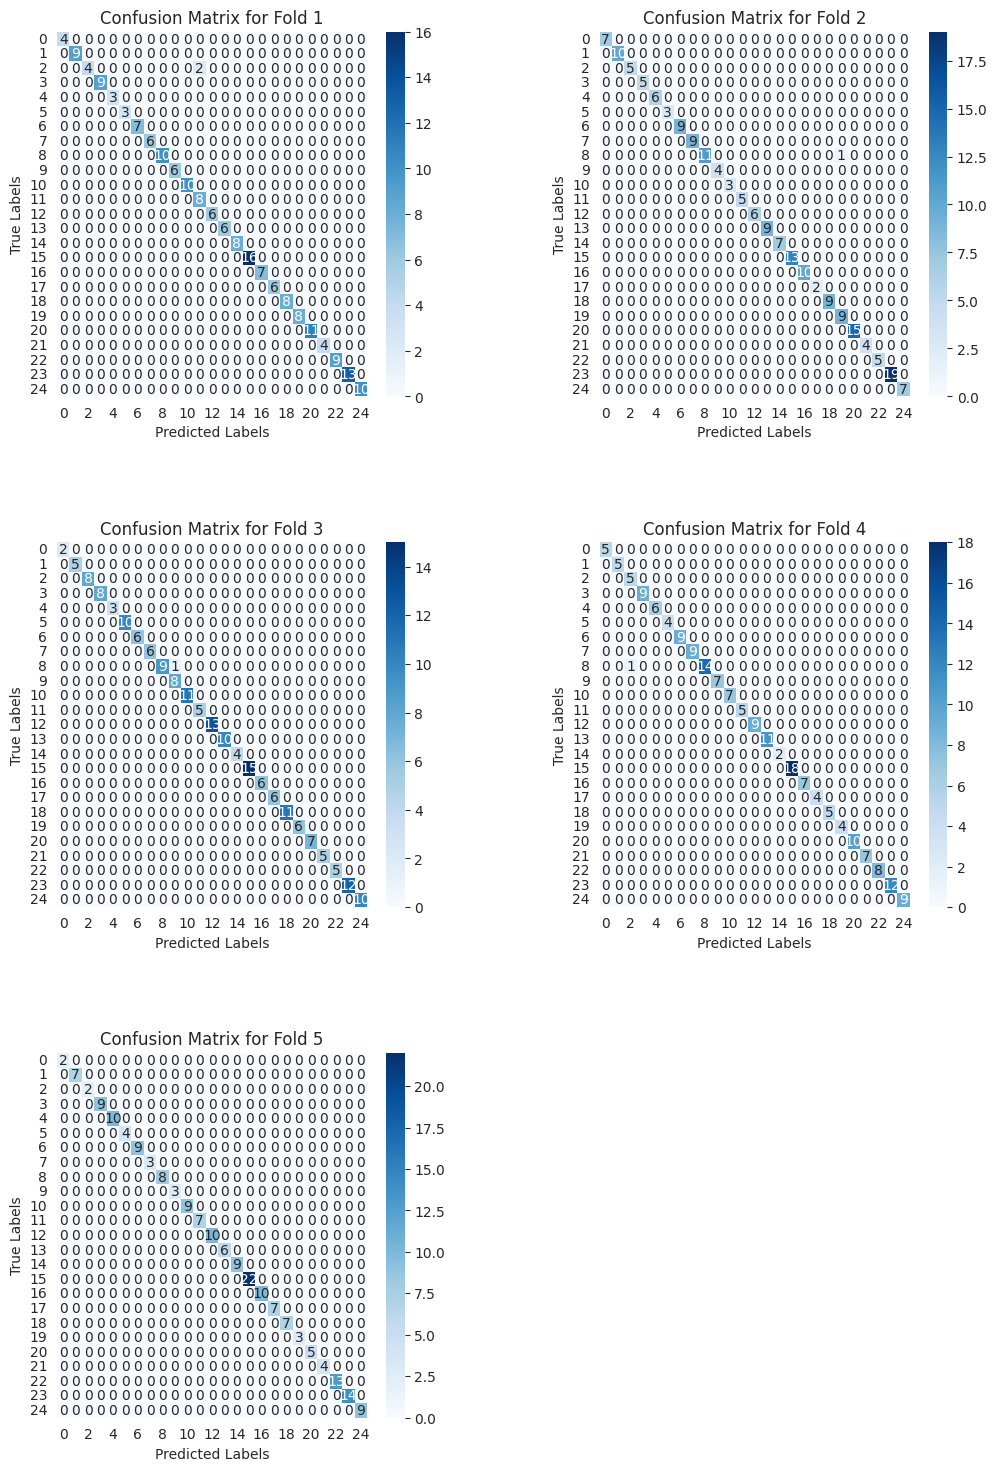

In [ ]:
# vectorizing cleaned columns
text = df['Cleaned_Resume'].values
target = df['Target'].values

tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=False,
    stop_words='english',
    max_features=500
)
features = tfidf_vectorizer.fit_transform(raw_documents=text)

# encode target variable
label = LabelEncoder()
y_encoded = label.fit_transform(target)

# define CV procedure
cv = KFold(n_splits=5, random_state=24, shuffle=True)

# define model
svm_model_tfidf = SVC(kernel='linear', probability=True, random_state=42)

# store each fold's performance metrics
accuracies, precisions, recalls, f1_scores = [], [], [], []

# prep confusion matrix plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# perform manual K-Fold CV
for i, (train_index, test_index) in enumerate(cv.split(features)):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # train model
    svm_model_tfidf.fit(X_train, y_train)

    # prediction
    y_pred = svm_model_tfidf.predict(X_test)

    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # plot confusion matrix
    ax = axes.flatten()[i]
    sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {i + 1}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# hiding any unused subplots
for j in range(i + 1, axes.size):
    axes.flatten()[j].axis('off')

plt.show()

In [ ]:
# calculate and print average performance metrics
print(f"Average Validation Accuracy: {np.mean(accuracies) * 100:.1f}%")
print(f"Average Validation Precision: {np.mean(precisions) * 100:.1f}%")
print(f"Average Validation Recall: {np.mean(recalls) * 100:.1f}%")
print(f"Average Validation F1 Score: {np.mean(f1_scores) * 100:.1f}%")

Average Validation Accuracy: 99.5%
Average Validation Precision: 99.6%
Average Validation Recall: 99.5%
Average Validation F1 Score: 99.5%


##### 5.3.2) SVM Classifier, Word2Vec Vectorization

In [ ]:
# train Word2Vec model
model = Word2Vec(
    sentences = df['tokenized'],
    vector_size = 50,
    window = 3,
    min_count = 1,
    workers = 4,
    sg = 1
)

# define function to create a vector for a document
def document_vector(
    doc: List[str]
) -> np.ndarray:
    """
    Purpose: Generates a document vector by averaging the word vectors of the words in the document.
    :param doc: List[str] representing tokenized words in a document.
    :return: np.ndarray representing the averaged vector of the document's words.
    """
    # remove out-of-vocabulary words
    doc = [
        word for word in doc if word in model.wv.index_to_key
    ]
    return np.mean(
        model.wv[doc],
        axis = 0
    )

# create document vectors for each resume
df['doc_vector'] = df['tokenized'].apply(
    lambda tokenized_resume: document_vector(
        doc = tokenized_resume
    )
)

In [ ]:
# prep data for modeling
X_word2vec = np.array(df['doc_vector'].tolist())
y = df['Category']

# encode target variable
label = LabelEncoder()
y_encoded = label.fit_transform(y)

# define model
svm_model = SVC(kernel='linear', probability=True, random_state=42)

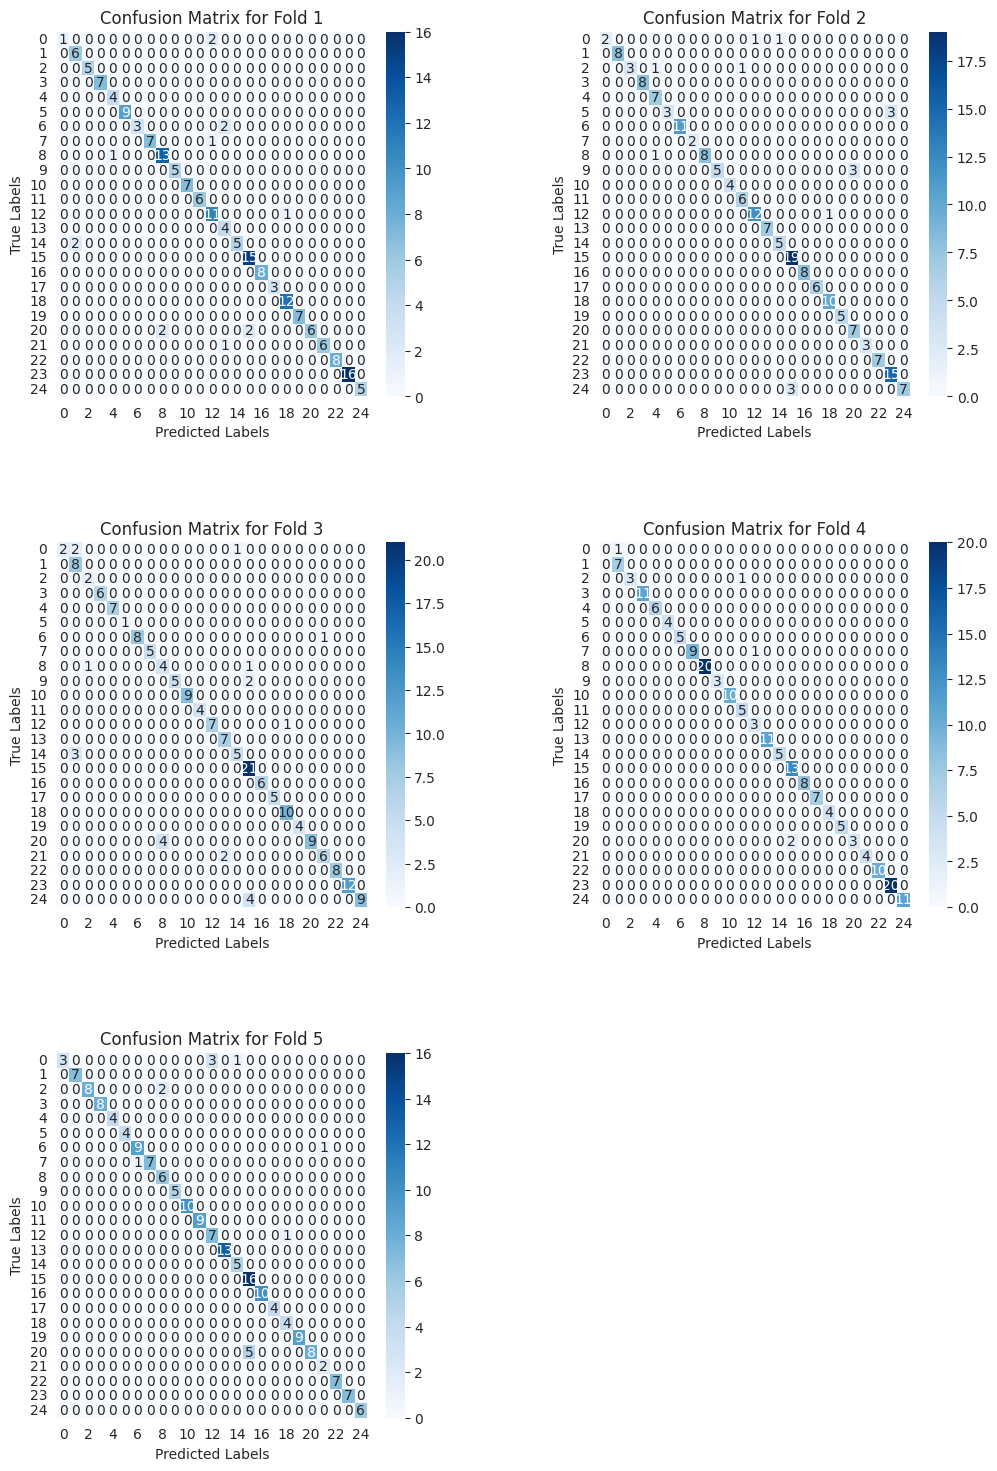

Average Validation Accuracy: 92.7%
Average Validation Precision: 94.1%
Average Validation Recall: 92.7%
Average Validation F1 Score: 92.4%


In [ ]:
# define CV procedure
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# store each fold's performance metrics
accuracies, precisions, recalls, f1_scores = [], [], [], []

# prep confusion matrix plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# perform manual K-Fold CV
for i, (train_index, test_index) in enumerate(cv.split(X_word2vec)):
    X_train, X_test = X_word2vec[train_index], X_word2vec[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # train model
    svm_model.fit(X_train, y_train)

    # prediction
    y_pred = svm_model.predict(X_test)

    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # plot confusion matrix
    ax = axes.flatten()[i]
    sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {i + 1}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# hiding any unused subplots
for j in range(i + 1, axes.size):
    axes.flatten()[j].axis('off')

plt.show()

# Calculate and print average performance metrics
print(f"Average Validation Accuracy: {np.mean(accuracies) * 100:.1f}%")
print(f"Average Validation Precision: {np.mean(precisions) * 100:.1f}%")
print(f"Average Validation Recall: {np.mean(recalls) * 100:.1f}%")
print(f"Average Validation F1 Score: {np.mean(f1_scores) * 100:.1f}%")

##### 5.3.3) SVM Classifier, GloVe Vectorization

In [ ]:
# Tokenize and preprocess the text
df['tokenized'] = df['Cleaned_Resume'].apply(
    lambda resume: word_tokenize(
        text = resume
    )
)

# vectorize resumes using GloVe
df['Vec_Resume_Glove'] = df['Cleaned_Resume'].apply(
    lambda resume: vectorize_text(
        text = resume,
        model = model_glove
    )
)

In [ ]:
# prepare data for modeling
X_glove = np.array(
    df['Vec_Resume_Glove'].tolist()
)
y = df['Category']

# encode target variable
label = LabelEncoder()
y_encoded = label.fit_transform(
    y
)

In [ ]:
# define model
svm_model_glove = SVC(kernel='linear', probability=True, random_state=42)

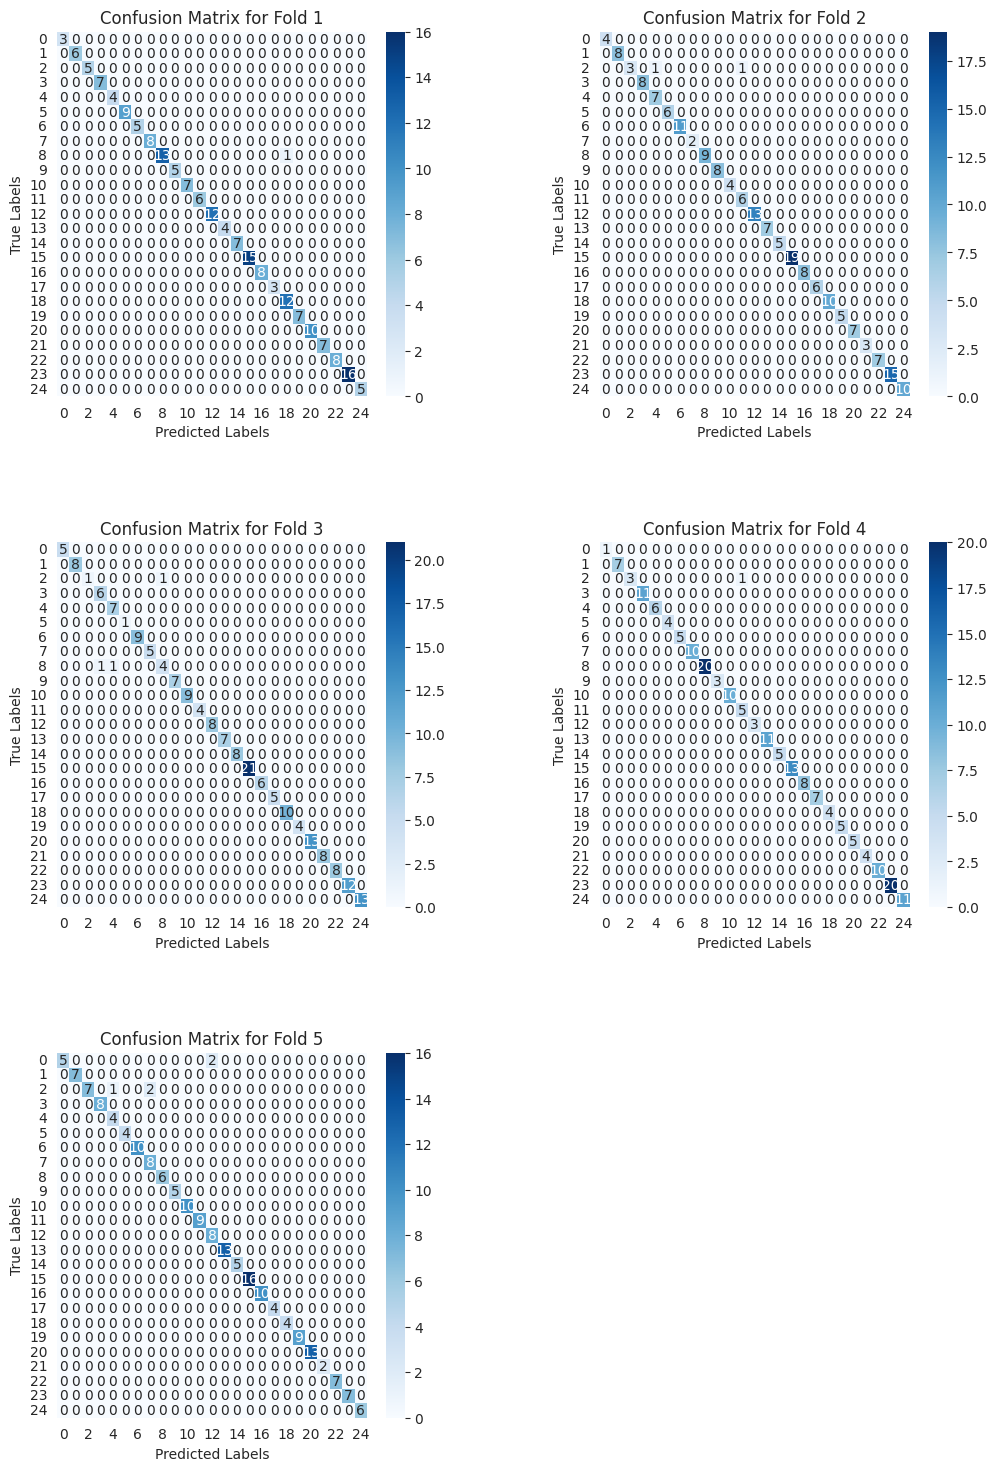

In [ ]:
# define CV procedure
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# store each fold's performance metrics
accuracies, precisions, recalls, f1_scores = [], [], [], []

# prep confusion matrix plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# perform manual K-Fold CV
for i, (train_index, test_index) in enumerate(cv.split(X_glove)):
    X_train, X_test = X_glove[train_index], X_glove[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # train model
    svm_model_glove.fit(X_train, y_train)

    # prediction
    y_pred = svm_model_glove.predict(X_test)

    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # plot confusion matrix
    ax = axes.flatten()[i]
    sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {i + 1}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# hiding any unused subplots
for j in range(i + 1, axes.size):
    axes.flatten()[j].axis('off')

plt.show()

In [ ]:
# calculate and print average performance metrics
print(f"Average Validation Accuracy: {np.mean(accuracies) * 100:.1f}%")
print(f"Average Validation Precision: {np.mean(precisions) * 100:.1f}%")
print(f"Average Validation Recall: {np.mean(recalls) * 100:.1f}%")
print(f"Average Validation F1 Score: {np.mean(f1_scores) * 100:.1f}%")

Average Validation Accuracy: 98.8%
Average Validation Precision: 98.9%
Average Validation Recall: 98.8%
Average Validation F1 Score: 98.7%


### **6. Observations and Discussion**

#### 6.1) Analysis of Model-Embedding Pair Performance

|    Model    |  Embedding  | Training Accuracy | Validation Accuracy |
|-------------|-------------|-------------------|---------------------|
| One-vs-Rest |   TF-IDF    |       97.9%       |        97.5%        |
| One-vs-Rest |  Word2Vec   |       96.9%       |        94.0%        |
| One-vs-Rest |    GloVe    |       97.4%       |        94.5%        |
|     MLP     |   TF-IDF    |      100.0%       |        99.7%        |
|     MLP     |  Word2Vec   |       80.5%       |        84.1%        |
|     MLP     |    GloVe    |       98.7%       |        99.4%        |
|     SVM     |   TF-IDF    |       99.9%       |        99.5%        |
|     SVM     |  Word2Vec   |       95.5%       |        92.7%        |
|     SVM     |    GloVe    |       99.7%       |        98.8%        |

The performance data for various model-embedding combinations highlights distinct variations in validation accuracy, showcasing the effectiveness of specific embeddings with different models. The MLP model achieves exceptional performance with TF-IDF and GloVe embeddings, registering validation accuracies of 99.7% and 99.4%, respectively, illustrating their strong generalization capabilities. In contrast, MLP's performance with Word2Vec significantly drops, suggesting limitations in capturing the essential features necessary for effective classification in this setting.

Similarly, the SVM model performs best with TF-IDF at 99.5% accuracy, affirming TF-IDF's capability in effectively handling SVM's linear classification approach. GloVe also shows strong performance across models, particularly with SVM and MLP, though it performs slightly lower with the One-vs-Rest classifier. This highlights importance of selecting appropriate embedding techniques based on the model's nature and the data characteristics to optimize classification accuracy.

#### 6.2) Analysis of Frequently Misclassified Resumes

Analyzing misclassified resumes across different models and embeddings, several patterns and potential reasons for these misclassifications emerge. For instance, the MLP classifier using TF-IDF vectorization misclassified a resume that heavily detailed project and program management skills along with technical skills like Python and DevOps. This resume was predicted as "Web Designing" instead of its true category, "ETL Developer." The presence of diverse skills that cross multiple job domains may confuse the model, especially under vectorizations like TF-IDF which prioritize term frequency over context.

Another notable misclassification involves the Word2Vec embedding with the MLP model, where resumes with extensive details on project management, technical skills, and software proficiency were often misclassified into unrelated job categories. This could suggest that Word2Vec, while capturing semantic meanings, might not adequately differentiate the context or importance of terms specific to the job categories in question. Resumes with mixed skill sets across various domains seem particularly prone to this, as the model might latch onto commonly misrepresented terms or skills that appear significant but are contextually irrelevant for the target job category.

Moreover, resumes detailed with specific technologies and methodologies, like those involving SAP or project management software, were occasionally mispredicted by models trained on GloVe embeddings. This might be due to GloVe's pre-trained nature, which although it provides a robust general understanding of language, may not translate well to very niche or industry-specific terminology without sufficient training data. The misclassifications often involved assigning these resumes to more general or broadly related fields, indicating a potential dilution of industry-specific signals in the embeddings. These insights suggest that while embeddings capture linguistic nuances, their effectiveness is contingent on the alignment of their training corpus with the domain-specific language of the resumes.